In [1]:
import os
import time
import random
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import pandas_datareader as pdr
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV

from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from kerashypetune import KerasGridSearch,KerasGridSearchCV, KerasRandomSearchCV

%matplotlib inline
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
def set_seed_TF2(seed): 
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

### 1. Load Stock Price Data

In [3]:
#GET THE STOCK QUOTE, THE PRICE IS UPDATED REFLECTING THE SPLITS / REVERSE-SPLITS
ticker='GS'
df = pdr.DataReader(ticker,data_source='yahoo',start='2000-01-01',end=datetime.date.today().strftime('%Y-%m-%d')).reset_index()
#REMOVE LAST COLUMN -'ADJ CLOSE'
df.drop(df.columns[-1],1,inplace=True)
#BACKUP DATASET
df_bkp=df.copy()
df.head()

Date     High     Low     Open    Close     Volume
0 2000-01-03  94.3750  87.750  94.1875  88.3125  1822600.0
1 2000-01-04  87.5000  82.250  87.0000  82.7500  1647700.0
2 2000-01-05  81.8750  78.375  80.8750  78.8750  1516600.0
3 2000-01-06  84.5000  78.625  78.6250  82.2500  1845100.0
4 2000-01-07  83.1875  79.875  83.0625  82.5625  1127400.0

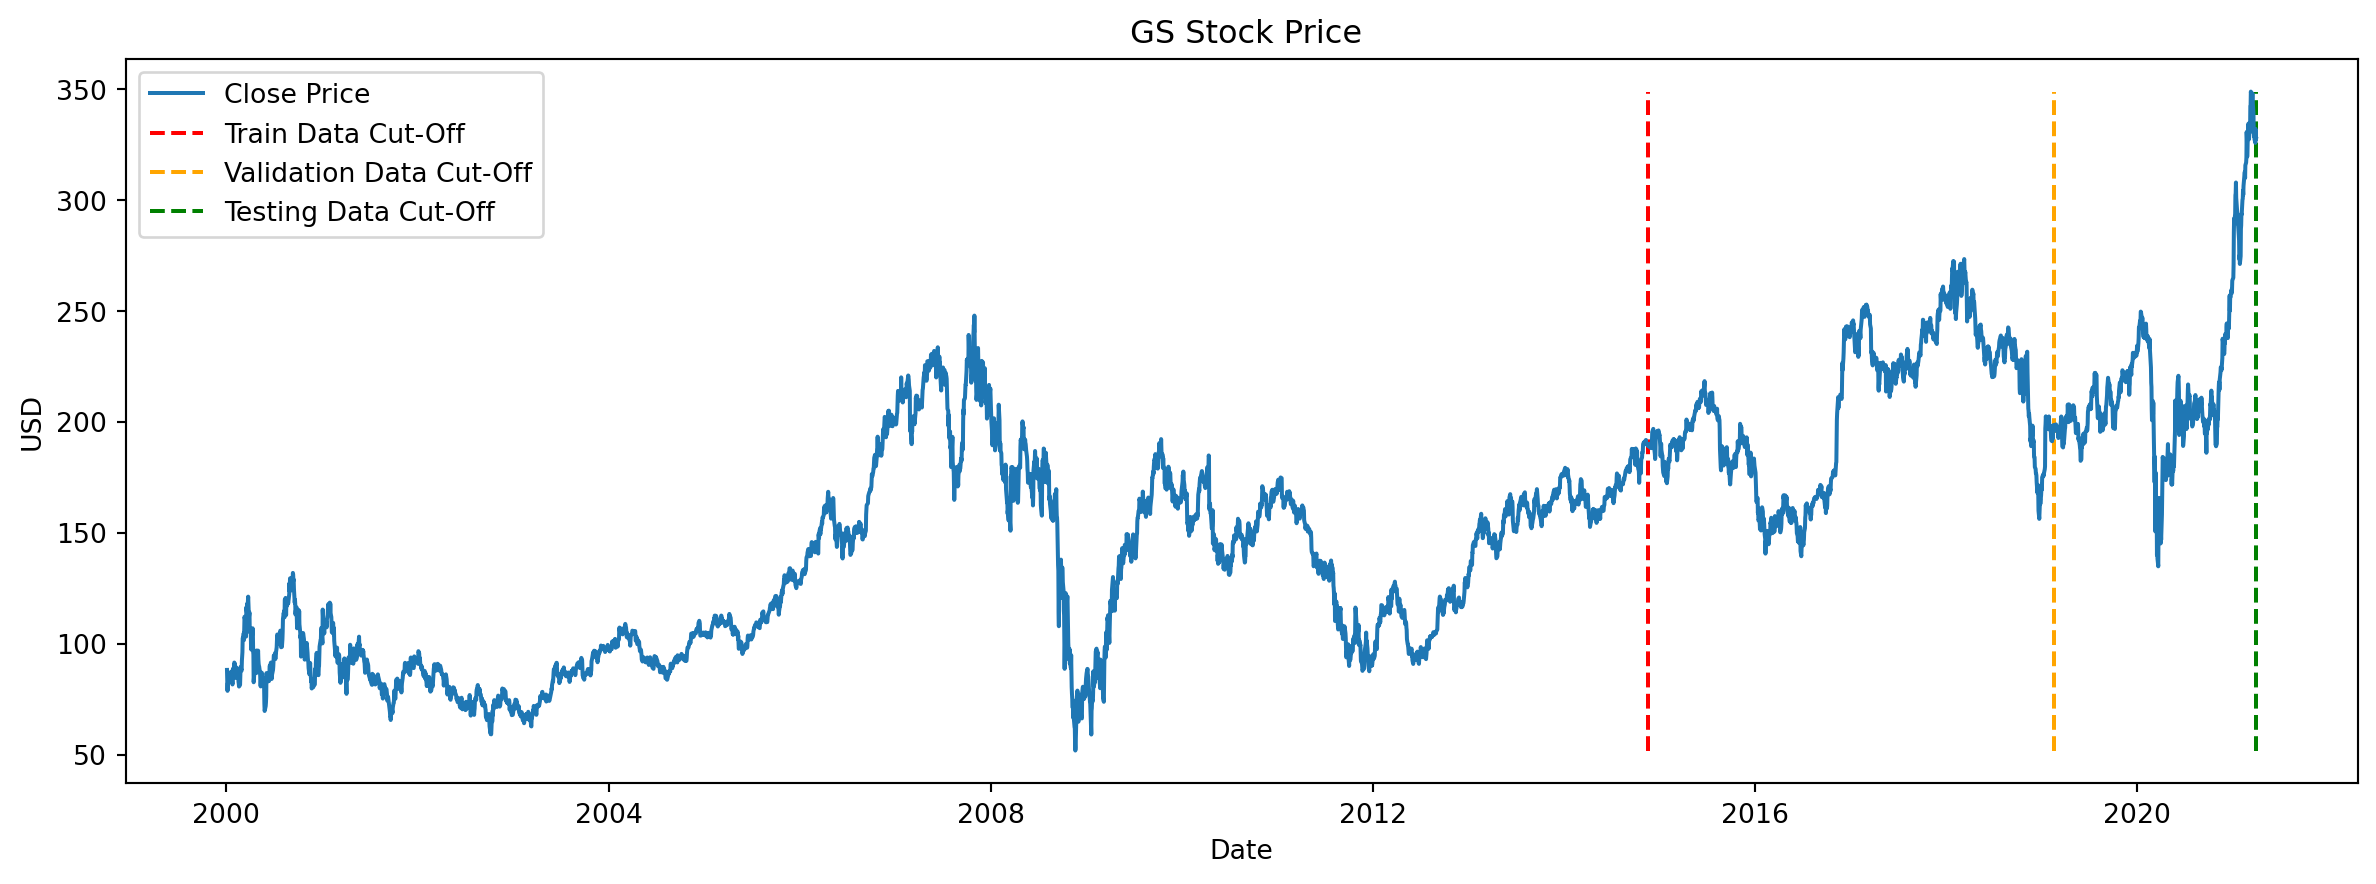

In [4]:
plt.figure(figsize=(15, 5), dpi=96)
plt.plot(df.Date, df.Close, label='Close Price')
plt.vlines(df.iloc[int(np.round(len(df)*0.7)),0], min(df.Close), max(df.Close), linestyles='--', colors='red', label='Train Data Cut-Off')
plt.vlines(df.iloc[int(np.round(len(df)*0.9)),0], min(df.Close), max(df.Close), linestyles='--', colors='orange', label='Validation Data Cut-Off')
plt.vlines(df.iloc[len(df)-1,0], min(df.Close), max(df.Close), linestyles='--', colors='green', label='Testing Data Cut-Off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title(f' {ticker} Stock Price')
plt.legend(loc='best')
plt.show()

In [5]:
training_days = int(df.shape[0]*.7)
validation_days = int(df.shape[0]*.2+1)
print('Training days: {}\nValidation days: {}\nTesting days: {}'.format(training_days,validation_days,df.shape[0]-training_days-validation_days))

Training days: 3742
Validation days: 1070
Testing days: 534


### 2. Plot Daily Closing Price & Volume

- Both Price Features & Volume will be used as an input for the model
- The graph below depicts a difference in terms of data scale which lead us to normalize the data

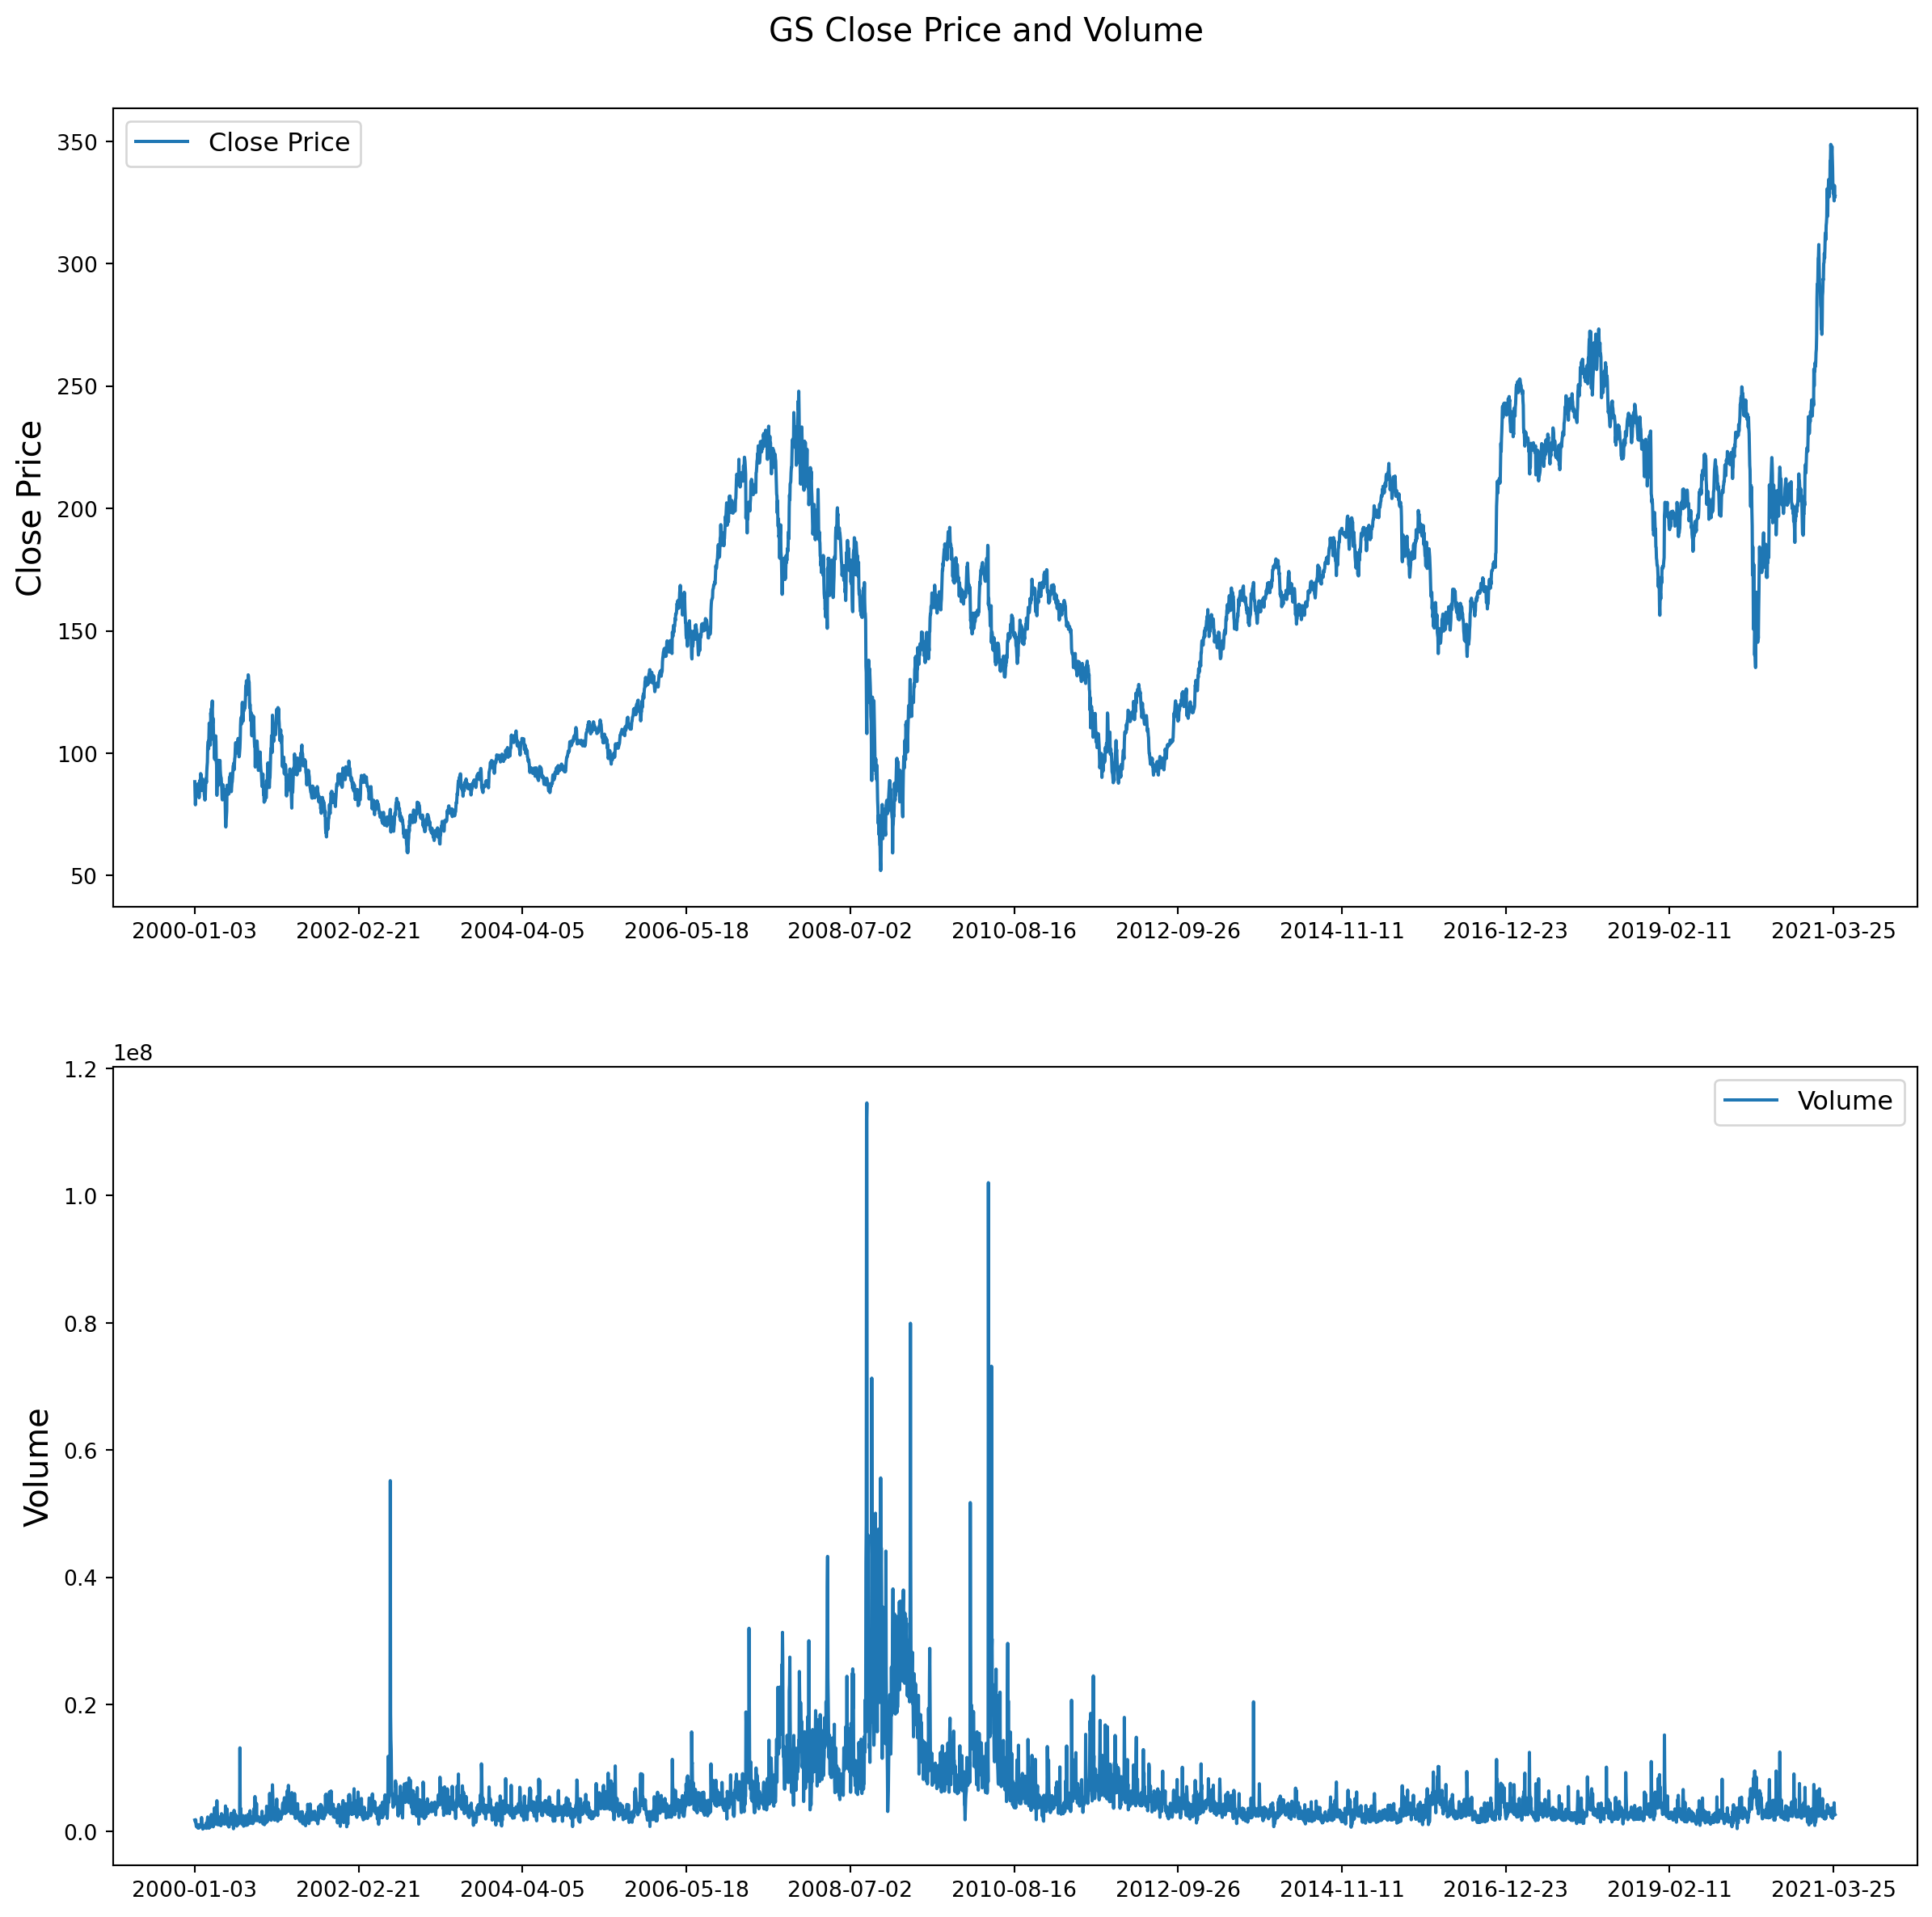

In [6]:
fig = plt.figure(figsize=(15,15), dpi=96)
st = fig.suptitle(f'{ticker} Close Price and Volume', fontsize=15)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df.Close, label='Close Price')
ax1.set_xticks(range(0, df.shape[0], int(len(df)/10)))
ax1.set_xticklabels(df.Date.loc[::int(len(df)/10)].dt.date)
ax1.set_ylabel('Close Price', fontsize=15)
ax1.legend(loc='best', fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df.Volume, label='Volume')
ax2.set_xticks(range(0, df.shape[0], int(len(df)/10)))
ax2.set_xticklabels(df.Date.loc[::int(len(df)/10)].dt.date)
ax2.set_ylabel('Volume', fontsize=15)
ax2.legend(loc='best', fontsize=12);

### Functions used to plot and split dataset into training, validation and testing

- First 70% for training the model
- Next last 20% for validation 
- Last 10 % for testing

In [215]:
def get_train_test_data (data, pct1=10, pct2=30):
    df=data.copy()
    df.dropna(how='any', axis=0, inplace=True) #Drop all rows with NaN values
    
    #Check if reset_index is needed
    if isinstance (df.index[0], datetime.date): df.reset_index(inplace=True)
    n_pct1 = sorted(df.index.values)[-int((pct1/100)*len(df.index.values))] #pct1% of series
    n_pct2 = sorted(df.index.values)[-int((pct2/100)*len(df.index.values))] #pct2% of series
    df_train = df[(df.index < n_pct2)] 
    df_val = df[(df.index >= n_pct2) & (df.index < n_pct1)]  
    df_test = df[(df.index >= n_pct1)]

    #Remove date column
    if 'Date' in df_train: df_train.drop('Date', 1, inplace=True)
    if 'Date' in df_val: df_val.drop('Date', 1, inplace=True)
    if 'Date' in df_test: df_test.drop('Date', 1, inplace=True)
    
    print('Training Data shape: {}'.format(df_train.values.shape))
    print('Validation Data shape: {}'.format(df_val.values.shape))
    print('Testing Data shape: {}'.format(df_test.values.shape))
    return df_train, df_val, df_test

In [8]:
def split_dataset (df, seq, title='Dataset'):
    df_x, df_y = [], []
    for i in range(seq, len(df)):
        df_x.append(df[i-seq:i]) #Dataset with a length of seq df-rows
        df_y.append(df.iloc[:,0].values[i]) #Value of 1st column (close) of df-row seq+1
    df_x, df_y = np.array(df_x), np.array(df_y)
    return df_x, df_y

In [9]:
def plot_data_separation(ticker, train_df, val_df, test_df, aField):
    sns.set_style('white')
    fig = plt.figure(figsize=(15,15))
    st = fig.suptitle(f'{ticker} Data Separation', fontsize=15)
    st.set_y(0.95)
    #Plot 1st feature for Training + Validation + Testing 
    ax1 = fig.add_subplot(211)
    ax1.plot(np.arange(train_df.shape[0]), train_df[aField[0]], label='Training Data')
    ax1.plot(np.arange(train_df.shape[0], 
                       train_df.shape[0]+val_df.shape[0]), val_df[aField[0]], label='Validation Data')
    ax1.plot(np.arange(train_df.shape[0]+val_df.shape[0], 
                       train_df.shape[0]+val_df.shape[0]+test_df.shape[0]), test_df[aField[0]], label='Test Data')
    #Set axis titles
    ax1.set_xlabel('Date', fontsize=15)
    ax1.set_ylabel(f'Normalized {aField[0]} Price', fontsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.set_title(f'{aField[0]} Price', fontsize=15)
    ax1.legend(loc='best', fontsize=15)
    
    #Plot 2nd feature for Training + Validation + Testing 
    ax2 = fig.add_subplot(212)
    ax2.plot(np.arange(train_df.shape[0]), train_df[aField[1]], label='Training Data')
    ax2.plot(np.arange(train_df.shape[0], 
                       train_df.shape[0]+val_df.shape[0]), val_df[aField[1]], label='Validation Data')
    ax2.plot(np.arange(train_df.shape[0]+val_df.shape[0], 
                       train_df.shape[0]+val_df.shape[0]+test_df.shape[0]), test_df[aField[1]], label='Test Data')
    #Set axis titles
    ax2.set_xlabel('Date', fontsize=15)
    ax2.set_ylabel(f'Normalized {aField[1]} Changes',fontsize=15)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_title(aField[1], fontsize=15)
    ax2.legend(loc='best', fontsize=15);

In [204]:
def norm_pct_minmax(df,l1,l2):
    #Apply percentage change
    for i in df.columns[l1:l2+1]: 
        df[i]=df[i].pct_change()
    df.dropna(how='any', axis=0, inplace=True) #Drop all rows with NaN values 
    #Normalize price columns
    min_value = min(df.iloc[:,l1:l2].min(axis=0))
    max_value = max(df.iloc[:,l1:l2].max(axis=0))
    for i in df.columns[l1:l2]: 
        df[i]=(df[i]-min_value)/(max_value-min_value) #Min & Max        
    #Normalize other columns
    min_value = df.iloc[:,l2].min(axis=0)
    max_value = df.iloc[:,l2].max(axis=0)
    for i in df.columns[l2:]: df[i] = (df[i]-min_value)/(max_value-min_value) #Min & Max
    return df

### Normalization - 1st approach

In [11]:
#Normalize dataset -> 1st:Price features , 2nd: Other columns
df=norm_pct_minmax(df,1,5)

### Split dataset into training, validation and testing

In [12]:
train_data,val_data,test_data=get_train_test_data(df)

Training Data shape: (3742, 5)
Validation Data shape: (1069, 5)
Testing Data shape: (534, 5)


### Plot datasets after being splitted

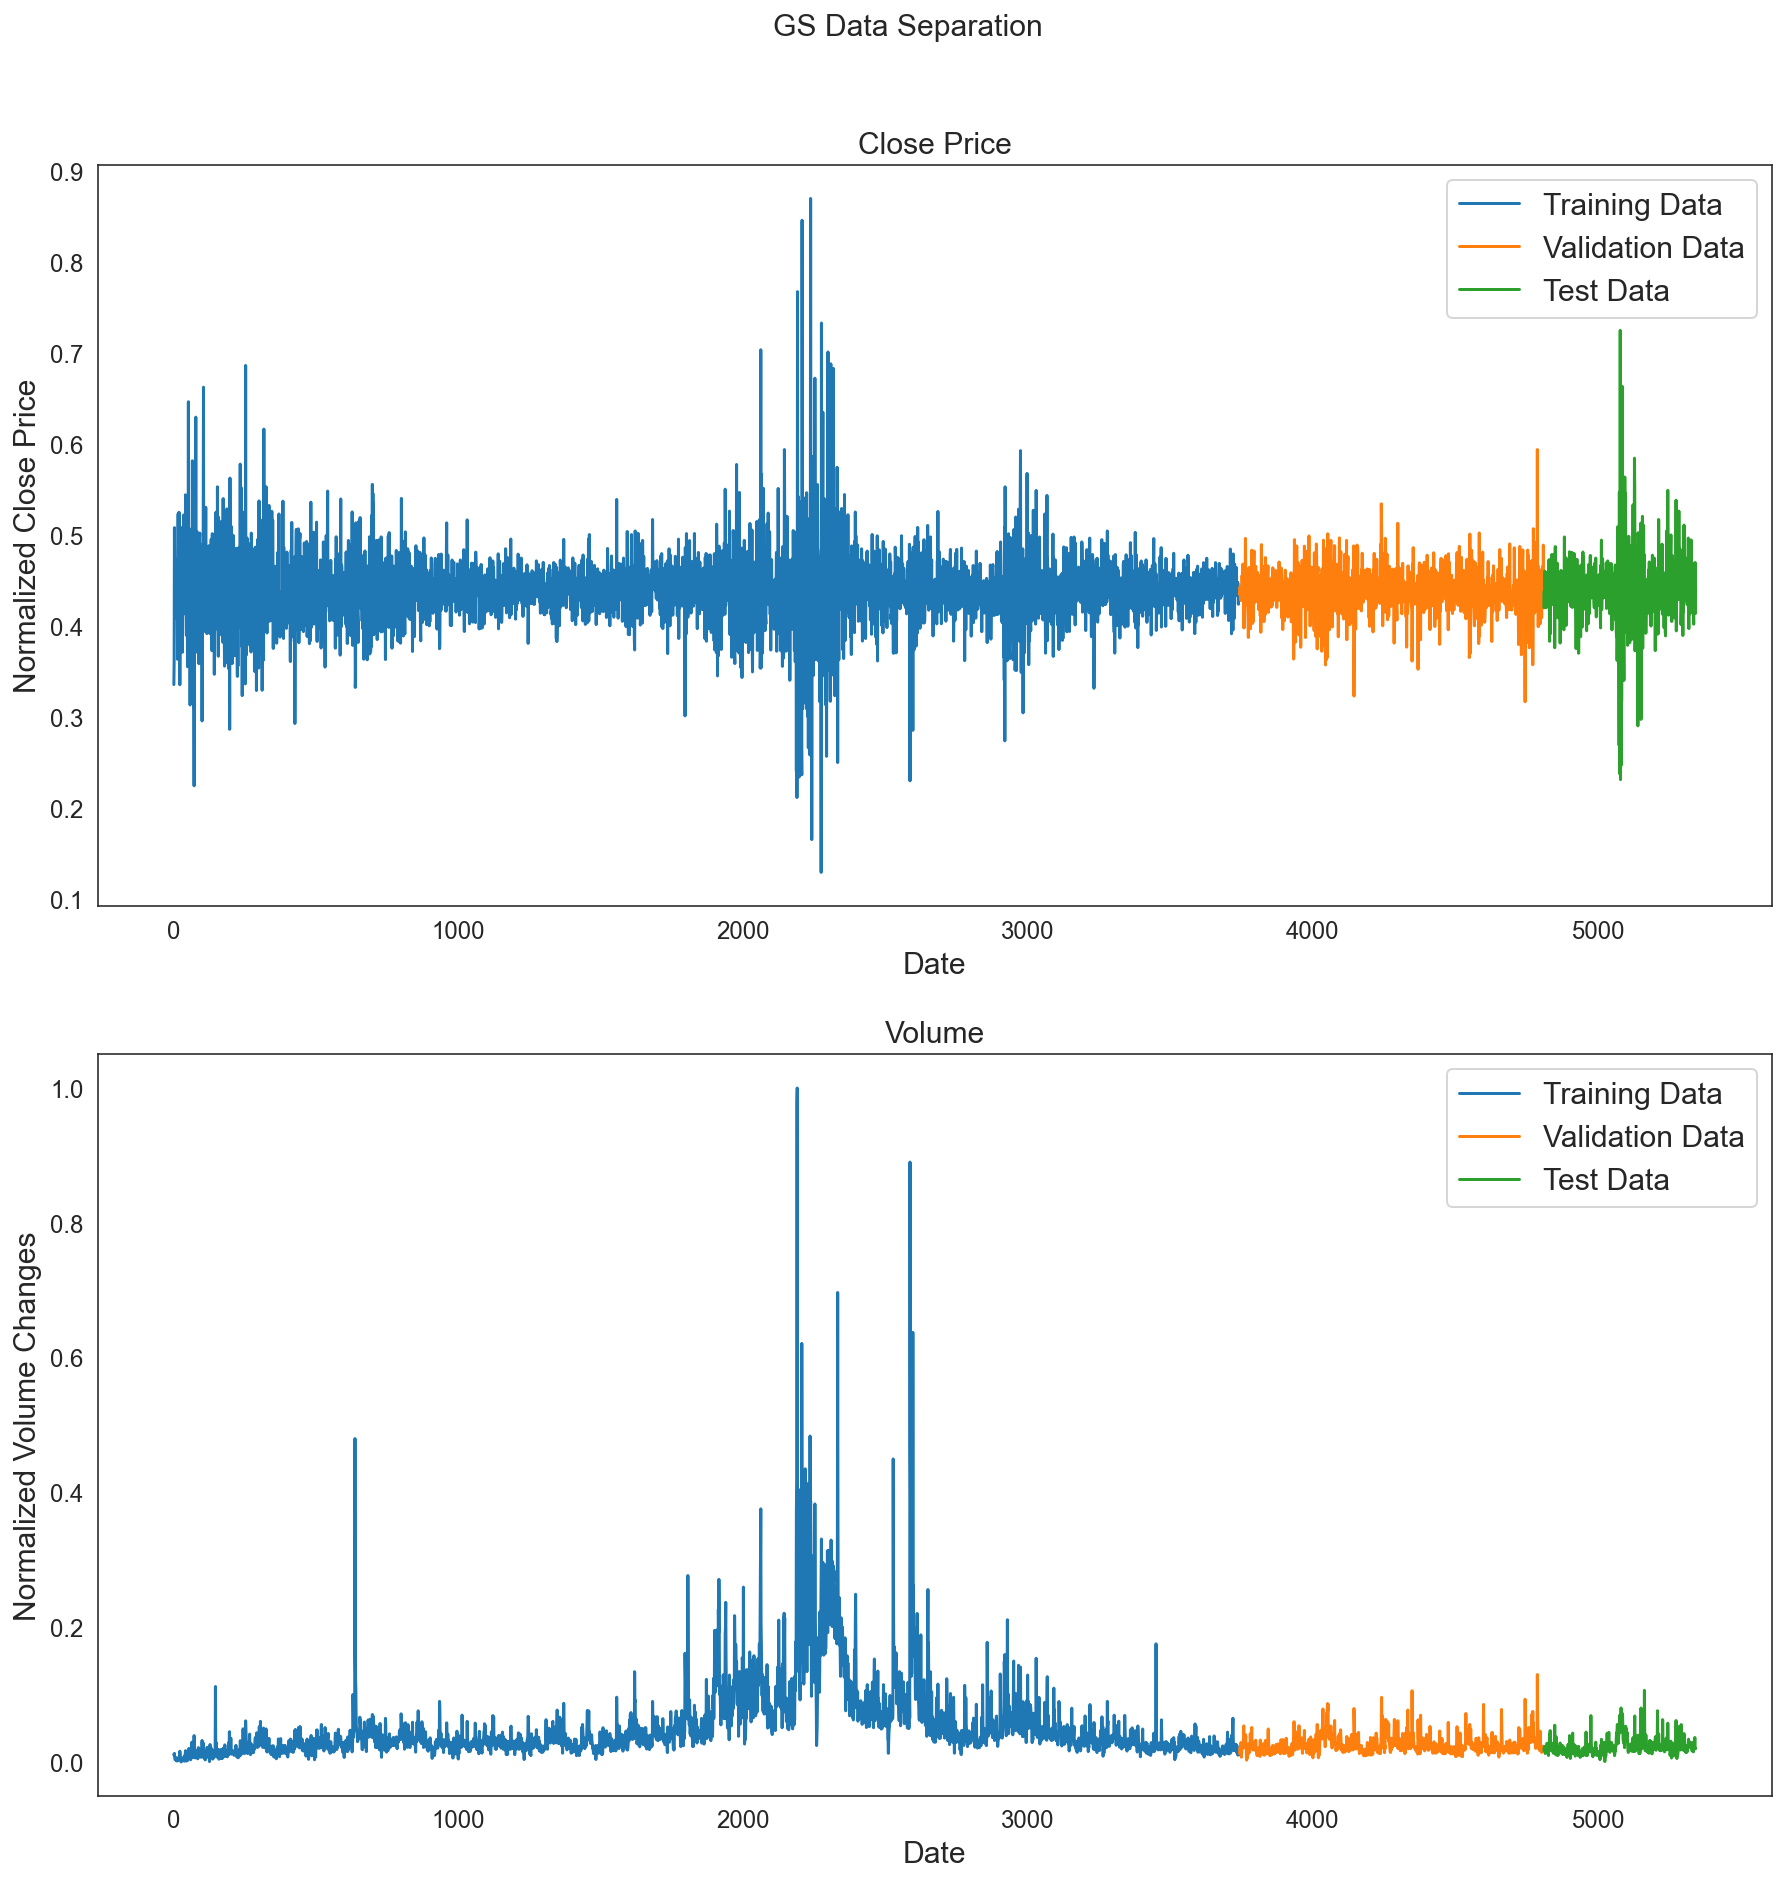

In [13]:
plot_data_separation(ticker, train_data, val_data, test_data, ['Close','Volume'])

### MinMax Normalization

- Initialise scaler to normalize the feature vectors
- Then fit the scaler on training data and eventually transform the data between 0 and 1
- This estimator scales and translates each feature individually such that it is in the given range on the training set

In [14]:
#GET TRAINING, VALIDATION & TESTING DATASET
train_data_upd,val_data_upd,test_data_upd=get_train_test_data(df_bkp)

Training Data shape: (3743, 5)
Validation Data shape: (1069, 5)
Testing Data shape: (534, 5)


In [15]:
minmax = MinMaxScaler(feature_range=(0,1)).fit(train_data_upd)
train_ndata = minmax.transform(train_data_upd)
val_ndata = minmax.transform(val_data_upd)
test_ndata = minmax.transform(test_data_upd)

### Plot datasets after being splitted

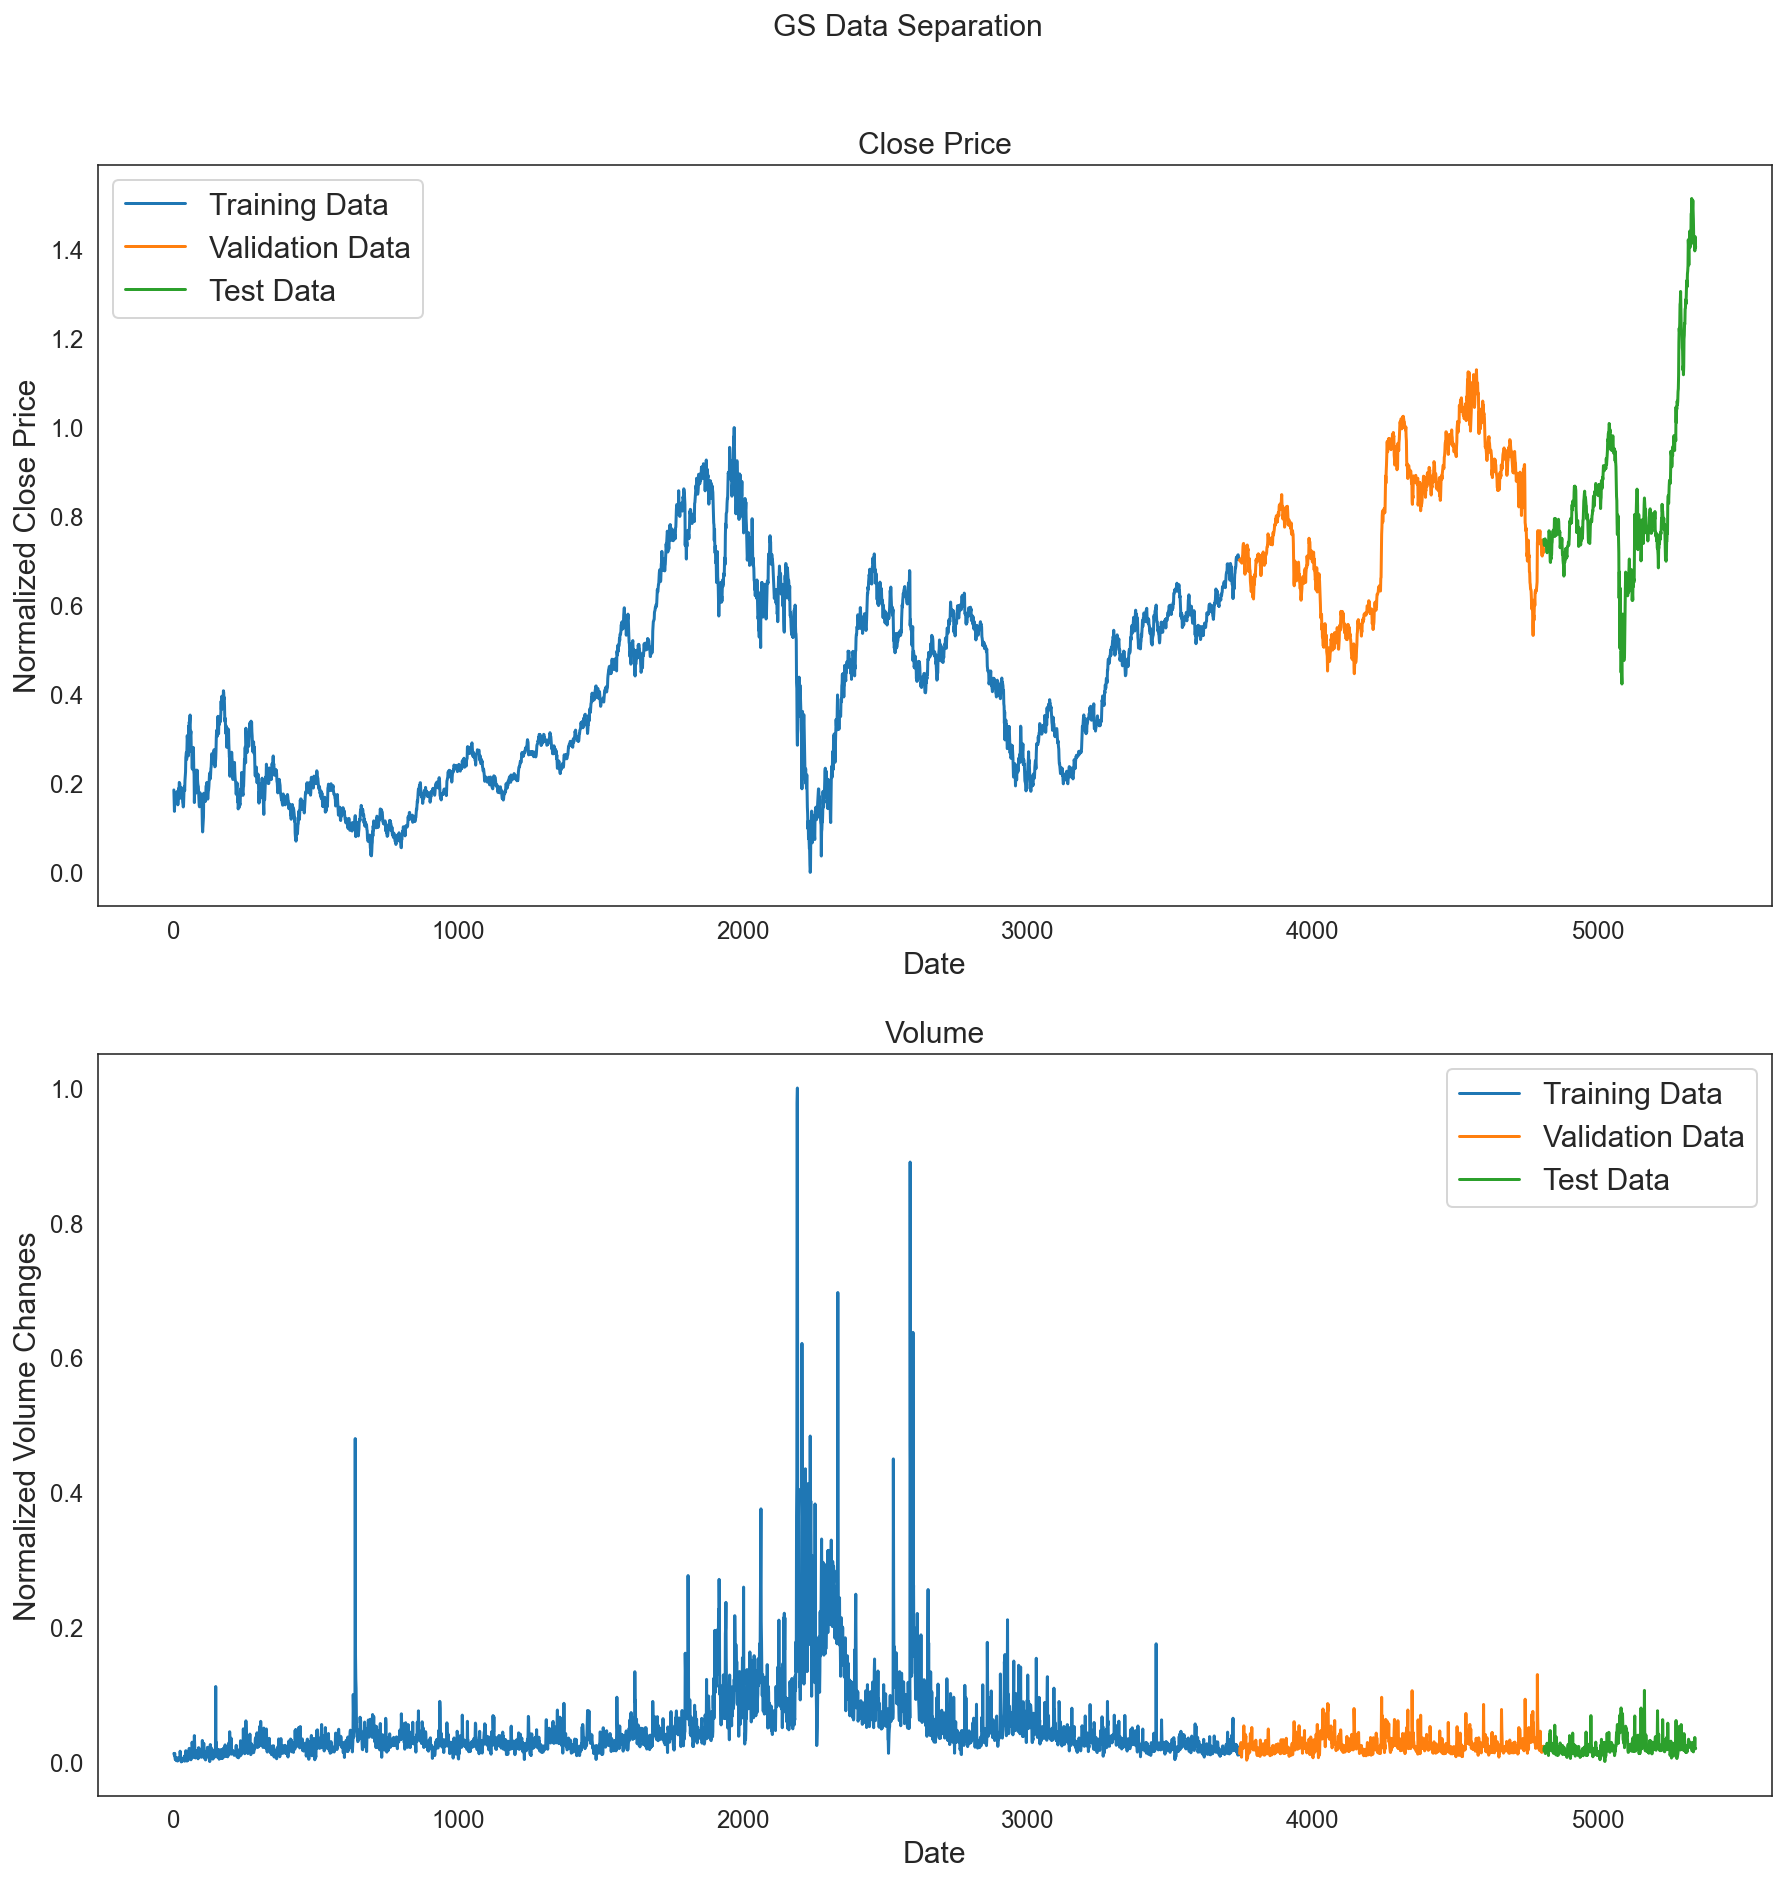

In [16]:
plot_data_separation(ticker,
                     pd.DataFrame(train_ndata,columns=train_data_upd.columns),
                     pd.DataFrame(val_ndata,columns=val_data_upd.columns),
                     pd.DataFrame(test_ndata,columns=test_data_upd.columns),
                     ['Close','Volume'])

### NN and Attention Parameters
- Heads:
    - Enables the encoding of multiple independent single head layers transformation into the model
    - Enables the model to focus on multiple time-series steps at once

In [99]:
#NN INITIAL PARAMETERES
batch_size = 32
seq_len = 128 #datasets are spllited into individual sequences with a length of 128 days each

#ATTENTION INITIAL PARAMETERS
d_k = 256 #key 
d_v = 256 #values
n_heads = 12 #attention heads
ff_dim = 256 #dimension

### Create chunks of training, validation and testing dataset

In [18]:
X_train, y_train = split_dataset(train_data,seq_len,'Training Set shape')
X_val, y_val = split_dataset(val_data,seq_len,'Validation Set shape')
X_test, y_test = split_dataset(test_data,seq_len,'Testing Set shape')

### Time2Vec

In [19]:
class Time2Vector(Layer):
      def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len
    
      def build(self, input_shape):
        #Initialize weights & biases with shape (batch_size, seq_len) for linear & periodic features
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)
        
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)
     
      def call(self, x):
        #Calculate linear features
        x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear #linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) #add dimension: (batch_size, seq_len, 1)
        #Calculate periodic features
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) #add dimension: (batch_size, seq_len, 1)
        #Concatenate linear & features and push into the single attention layers
        return tf.concat([time_linear, time_periodic], axis=-1)

      def get_config(self): 
        #Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

### Why Time2Vec?

- Fourier Transforms for extracting overall trend directions 
- According to Fourier sine-cosine series, any real-valued function f(t) that is integrable on an interval of length P can be approximated as
    - f(t) = a_0 + sum_{n=1}^{N/2} (a_n cos(2nt\pi/P) + b_n sin(2nt\pi/P)) 
- By choosing appropriate weights a_n and b_n. 
    - The cos functions can be replaced with sine functions so f(t) can be approximated with N sine functions.
- By concatenating Time2Vec to the input we allow 
    - The model to learn a function (or multiple functions) of time based on the data by taking a weighted sum
    - Learning a function of time from data rather than fixing it to a hand-crafted function can potentially lead to better generalization.

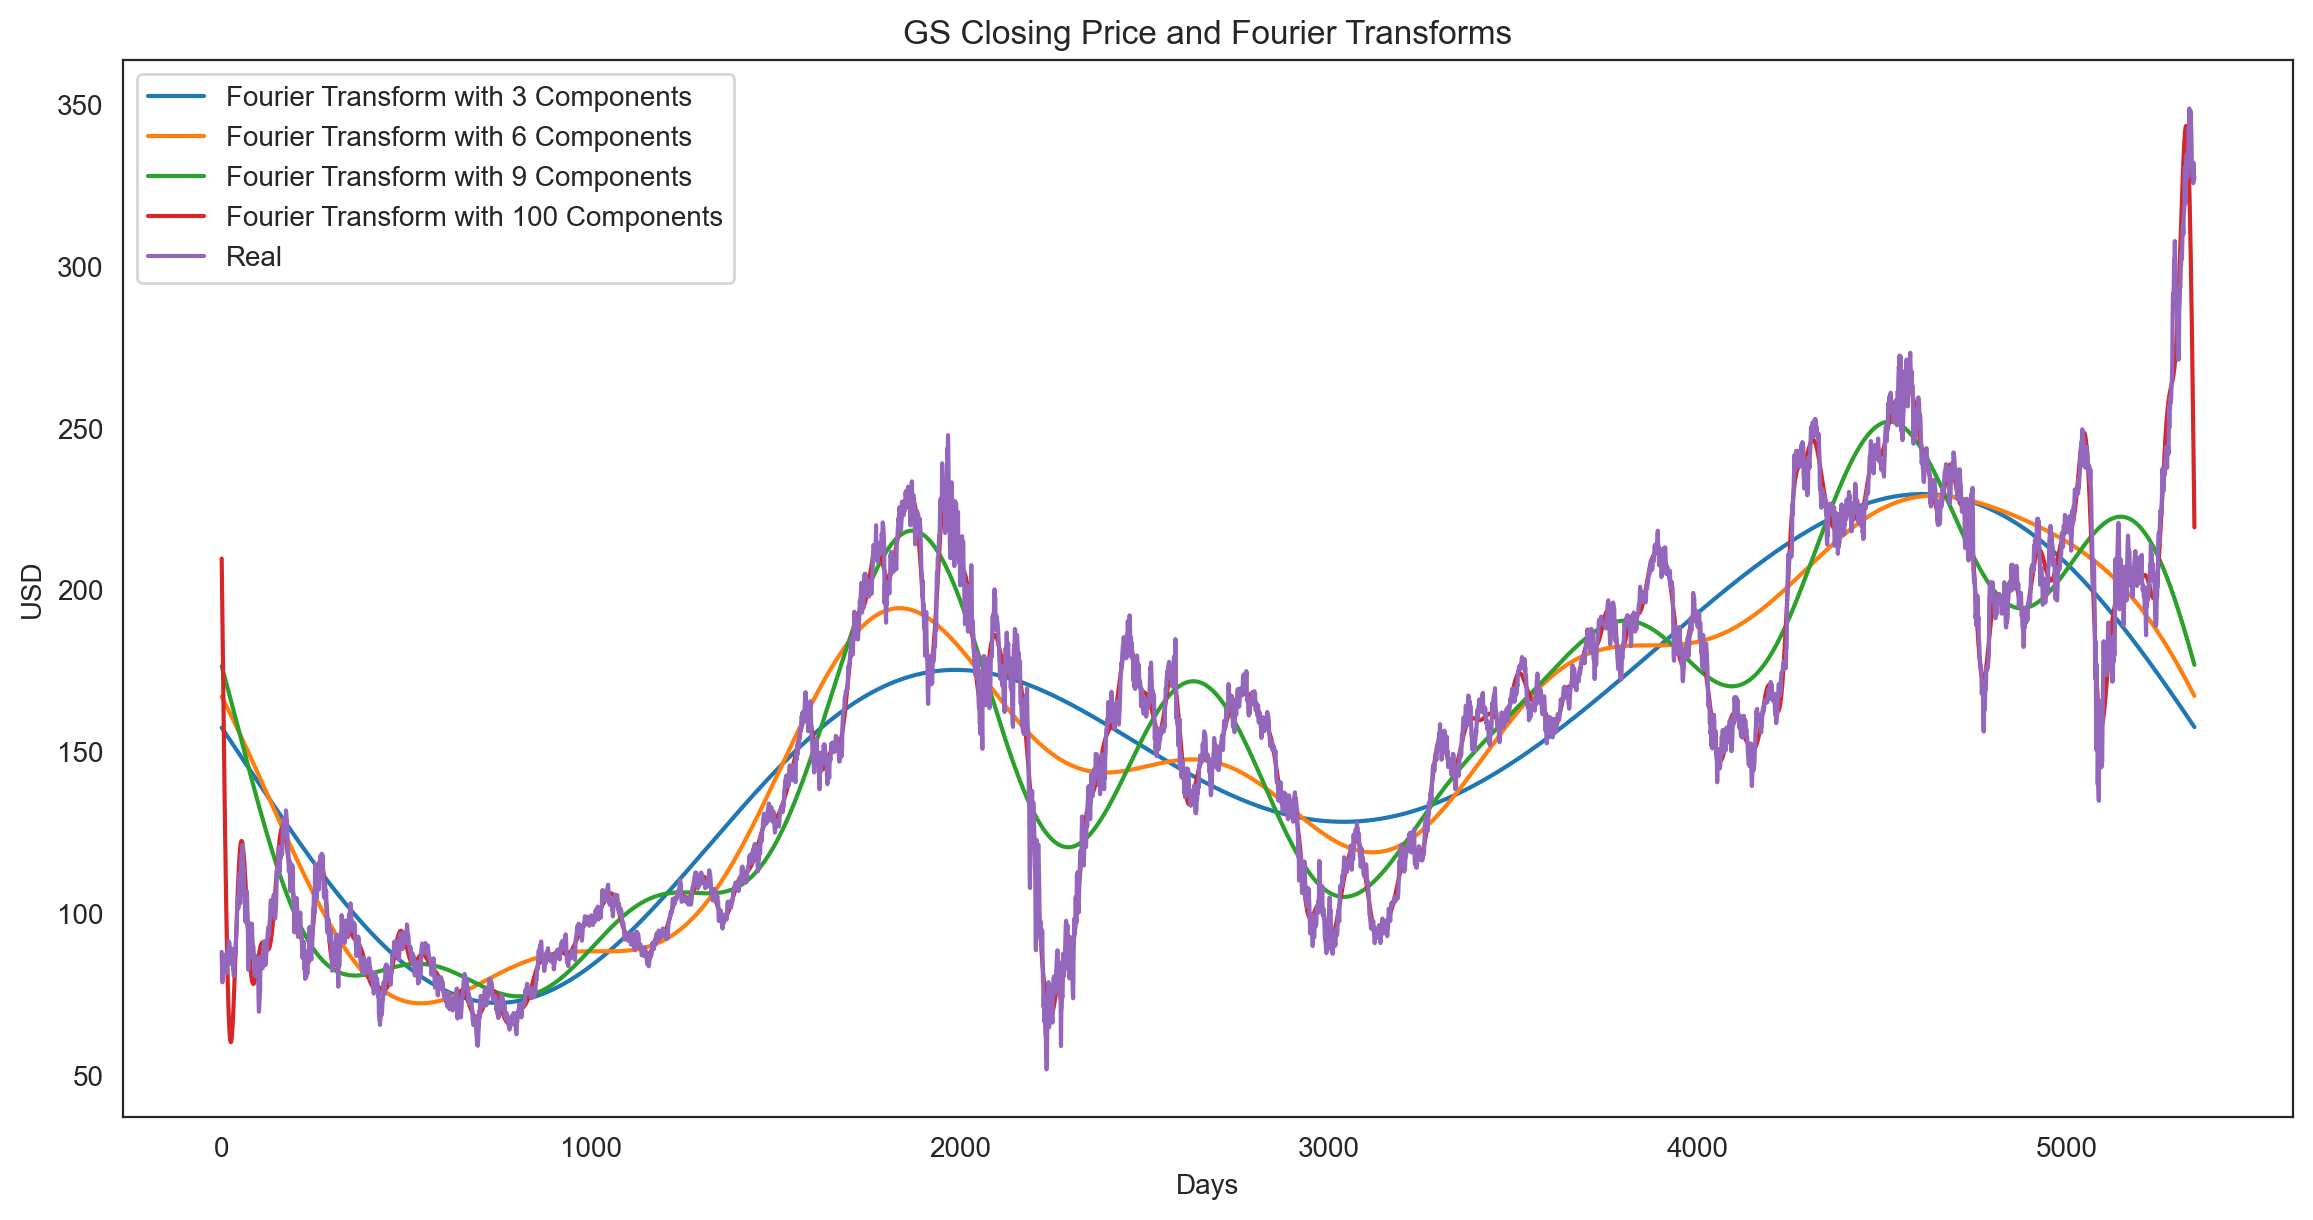

In [20]:
data_ft = df_bkp[['Date', 'Close']]
fft_df = pd.DataFrame({'fft':np.fft.fft(np.asarray(data_ft.Close.tolist()))})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())

for num_ in [3, 6, 9, 100]:
    fft_list_m= np.copy(fft_list); fft_list_m[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m), label='Fourier Transform with {} Components'.format(num_))

plt.plot(data_ft.Close,  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title(f'{ticker} Closing Price and Fourier Transforms')
plt.legend()
plt.show()

### Transformer
- Transformer
    - Each encoder layer incorporates a self-attention sublayer and a feedforward sublayer 
    - The feedforward sublayer consists of 2 dense layers with relu activation
- Kernel Initializer
    - Stands for an statistical distribution / function to use for initializing the weights
    - Using glorot uniform allows the attention to make samples from a uniform distribution encompassed between a range of [-limit to limit], this parameter could be tuned by replacing the initializer by he_normal a uniform distributed centered on 0
-  Attention:
    - Allows the network to focus on specific aspects of a complex input one at a time until the entire dataset is categorized

In [21]:
class SingleAttention(Layer):
      def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k #keys
        self.d_v = d_v #values
      
      def build(self, input_shape):
        #Each q,k,v receives a separate linear transformation by going through individual dense layers
        self.query = Dense(self.d_k, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')
        
        self.key = Dense(self.d_k, 
                         input_shape=input_shape, 
                         kernel_initializer='glorot_uniform', 
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v, 
                           input_shape=input_shape, 
                           kernel_initializer='glorot_uniform', 
                           bias_initializer='glorot_uniform')
      
      def call(self, inputs):
        #Query: input1[0]
        q = self.query(inputs[0])
        #Key: input[1]
        k = self.key(inputs[1])
        #Perform attention weights calculation
        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        #Applying softmax
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)
        #Values: input[2]
        v = self.value(inputs[2])
        #Once the value is retrieved will then be concatenated and pushed into a multi-attention layer
        attn_out = tf.matmul(attn_weights, v)
        return attn_out    

class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        #Iterates the number of multi-attention heads defined previously and 
        #Appends the output of single attentions into multi-attention layer
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  

        self.linear = Dense(input_shape[0][-1], 
                            input_shape=input_shape, 
                            kernel_initializer='glorot_uniform', 
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        #After appending into a single multi attention layer concatenate the elements
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        #The output will then be aggregated and pushed into a transformer layer
        return multi_linear   

class TransformerEncoder(Layer):
      def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        #Initialize properties
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout
    
      def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        #Applying Dropout & Normalization to prevent overfitting
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)     
        #Replacing the dense layers compouned within the feedforward sublayer by 2 Conv1D layers 
        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
        #Applying Dropout & Normalization to prevent overfitting
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
      def call(self, inputs):
        #Input grouped into (query,key,values)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)
        
        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer 

      def get_config(self): #Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config

### Construct the Model
   - Initialize Time & Transformers Layers
       - Invoke Time2Vector which will fit the data into a sine wave like function adding 2 more features which will get 
           - nonperiodic & periodic trends embeddeded into 2 new features 

In [92]:
def create_model(param, feat):
    #Initialize Time & Transformers layers
    time_embedding = Time2Vector(param['seq_len'])
    #Having obtained 2 new features push the output into a transformer and merge with the input features
    attn_layer1 = TransformerEncoder(param['d_k'], param['d_v'], param['n_heads'], param['ff_dim'])
    attn_layer2 = TransformerEncoder(param['d_k'], param['d_v'], param['n_heads'], param['ff_dim'])
    attn_layer3 = TransformerEncoder(param['d_k'], param['d_v'], param['n_heads'], param['ff_dim'])
    #Construct the Model
    in_seq = Input(shape=(param['seq_len'], feat))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    #For each feature dimension takes average among all time_steps having an output of (batch_size,1,features)
    #Flatten the remaining dimensions to reshape the tensor into a (batch_size, feature) dimension
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(param['dp'])(x)
    x = Dense(64, activation=param['act'])(x)
    x = Dropout(param['dp'])(x)
    out = Dense(1, activation='linear')(x)
    #Compile the Model
    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer=param['optimizer'], metrics=['mae', 'mape'])
    return model

### Model Architecture Summary

In [93]:
param_grid_model={'d_k':d_k, 'd_v':d_v,'n_heads':n_heads, 
                  'ff_dim':ff_dim,'seq_len':seq_len,'act':'relu',
                  'dp':0.1,'optimizer':'adam'}

In [94]:
model = create_model(param=param_grid_model,feat=len(train_data.columns))
model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
time2_vector_17 (Time2Vector)   (None, 128, 2)       512         input_17[0][0]                   
__________________________________________________________________________________________________
concatenate_16 (Concatenate)    (None, 128, 7)       0           input_17[0][0]                   
                                                                 time2_vector_17[0][0]            
__________________________________________________________________________________________________
transformer_encoder_51 (Transfo (None, 128, 7)       99114       concatenate_16[0][0] 

### Set Hyperparameters 
   - EarlyStopping - Stop training when a monitored metric has stopped improving
     - monitor: quantity to be monitored
     - min_delta: minimum change in the monitored quantity to qualify as an improvement, 
        - i.e. an absolute change of less than min_delta, will count as no improvement
        - patience: number of epochs with no improvement after which training will be stopped
   - ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving
     - factor - factor by which the learning rate will be reduced
        - new_lr = lr x factor

In [95]:
#The below hyperparameters can be used with KerasGridSearchCV / KerasRandomizedSearchCV
param_grid_hyper={'d_k':d_k, 'd_v':d_v, 'n_heads':n_heads, 
                  'ff_dim':ff_dim,'seq_len':seq_len,'dp':[0.1,0.2],
                  'epochs':[35,50,75],'batch_size':[32, 64],
                  'act':['elu','relu'],'optimizer':['SGD','RMSprop','adam']}

In [96]:
#Features to be used in the model: [High, Low, Open, Close, Volume]
hypermodel = lambda x: create_model(param=x, feat=len(train_data.columns))

In [124]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint('model.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

### Run Hyperparameters Search

- Performing search by using: 
    - KerasGridSearchCV
    - KerasRandomSearchCV

- The hyperparameters could be run on demand of the user, as depicted below we run the KerasGridSearchCV 
- However it will take a considerable number of hours to process as we are passing 72 combinations, we left the code commented

In [ ]:
#cv = KFold(n_splits=3, random_state=33, shuffle=False)

#### KerasGridSearch

In [65]:
#kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
#kgs.set_seed(set_seed_TF2)

In [66]:
#kgs.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[es, rlr, mcp])


3 trials detected for ('d_k', 'd_v', 'n_heads', 'ff_dim', 'seq_len', 'act', 'dp', 'optimizer', 'epochs', 'batch_size')

***** (1/3) *****
Search({'d_k': 256, 'd_v': 256, 'n_heads': 12, 'ff_dim': 256, 'seq_len': 128, 'act': 'relu', 'dp': 0.1, 'optimizer': 'adam', 'epochs': 75, 'batch_size': 64})

Epoch 00001: val_loss improved from inf to 0.00050, saving model to model.hdf5

Epoch 00002: val_loss did not improve from 0.00050

Epoch 00003: val_loss did not improve from 0.00050

Epoch 00004: val_loss did not improve from 0.00050

Epoch 00005: val_loss did not improve from 0.00050

Epoch 00006: val_loss did not improve from 0.00050

Epoch 00007: val_loss did not improve from 0.00050

Epoch 00008: val_loss improved from 0.00050 to 0.00050, saving model to model.hdf5

Epoch 00009: val_loss did not improve from 0.00050

Epoch 00010: val_loss did not improve from 0.00050

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00011: val_loss did not improve fro

- Performing search by using:
    - KerasClassifier
    - GridSearchCV
    - RandomSearchCV

#### GridSearchCV & RandomizedSearchCV

In [132]:
model_keras = KerasClassifier(hypermodel, verbose=1)
#GridSearchCV
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid, n_jobs=-1, cv=cv)
result = grid.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[es, rlr, mcp])

#RandomizedSearchCV
#random = RandomizedSearchCV(estimator=model_keras, param_distributions=param_grid, n_jobs=-1, cv=cv, verbose=20, random_state=33)
#result = random.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[es, rlr, mcp], random_state=33)

- Summary Results

In [ ]:
print('Best: %f using %s' % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params): 
    print('%f (%f) with: %r' % (mean, stdev, param))

### Running the Model without Hyperparamters (this is the fastest option)

In [98]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=35, callbacks=[es, rlr, mcp], validation_data=(X_val, y_val))

Epoch 1/35
113/113 [==============================] - ETA: 0s - loss: 0.0236 - mae: 0.0930 - mape: 21.1921
Epoch 00001: val_loss improved from inf to 0.00053, saving model to model.hdf5
113/113 [==============================] - 117s 1s/step - loss: 0.0236 - mae: 0.0930 - mape: 21.1921 - val_loss: 5.3245e-04 - val_mae: 0.0171 - val_mape: 3.8701
Epoch 2/35
113/113 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0361 - mape: 8.2976
Epoch 00002: val_loss did not improve from 0.00053
113/113 [==============================] - 114s 1s/step - loss: 0.0022 - mae: 0.0361 - mape: 8.2976 - val_loss: 5.3366e-04 - val_mae: 0.0171 - val_mape: 3.9755
Epoch 3/35
113/113 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0355 - mape: 8.1511
Epoch 00003: val_loss did not improve from 0.00053
113/113 [==============================] - 115s 1s/step - loss: 0.0022 - mae: 0.0355 - mape: 8.1511 - val_loss: 5.7259e-04 - val_mae: 0.0179 - val_mape: 4.0419
Epoch 4/35
113/113 

### Load Model Based on Training

In [100]:
model = tf.keras.models.load_model(os.path.join(os.getcwd(),'model.hdf5'),
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

### Functions used to get predictions and metrics 

 - Get Predictions based on the model
 - Get Evaluation metrics across all datasets (training, evaluation & testing)
     - MSE: Mean Squared Error (Loss)
     - MAE: Mean Average Error
     - MPAE: Mean Average Percentage Error

In [101]:
def calc_predict(model,aDf):
    dic={}
    #0:training |1:validation |2:testing
    for i,value in enumerate(aDf): dic.update({i:model.predict(value)})
    return dic

In [102]:
def eval_metrics(model,aDf):
    dic={}
    #0:training |1:validation |2:testing
    for i,value in enumerate(aDf): dic.update({i:model.evaluate(value[0], value[1], verbose=0)})
    return dic 

In [103]:
def model_metric_summary(aDf):
    dic={}
    for i in range(len(aDf)): dic.update({i:aDf[i]})
    index_name=['Training','Validation','Testing']
    column_name = ['Loss (MSE)','MAE','MAPE']
    df = pd.DataFrame(index=index_name, columns=column_name)
    for i in range(len(aDf)):
        df.iloc[i,0] = dic[i][0]
        df.iloc[i,1] = dic[i][1]
        df.iloc[i,2] = dic[i][2]
    return df

In [104]:
#Get Predictions
pdic=calc_predict(model,[X_train,X_val,X_test])

In [105]:
#Get Evaluation Metrics
edic=eval_metrics(model,[[X_train, y_train],[X_val, y_val],[X_test,y_test]])

In [106]:
#Print Evaluation Metrics
model_metric_summary([edic[0],edic[1],edic[2]])

Loss (MSE)        MAE     MAPE
Training     0.00112425  0.0219363  5.05989
Validation  0.000499374  0.0163362   3.7543
Testing      0.00122242  0.0245815  5.62017

### Plot Prediction Results

In [107]:
def plot_prediction_result(pdic,aDf, title,seq=128):
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle(ticker + title, fontsize=22)
    st.set_y(0.95)
    
    #Plot Training Results
    ax11 = fig.add_subplot(311)
    ax11.plot(aDf[0].iloc[:,3], label=f'{ticker} Closing Returns')
    ax11.plot(np.arange(seq, pdic[0].shape[0]+seq), pdic[0], linewidth=3, label=f'Predicted {ticker} Closing Returns')
    ax11.set_title('Training Data', fontsize=18)
    ax11.set_xlabel('Date')
    ax11.set_ylabel(f'{ticker} Closing Returns')
    ax11.legend(loc='best', fontsize=12)

    #Plot Validation Results
    ax21 = fig.add_subplot(312)
    ax21.plot(aDf[1].iloc[:,3], label=f'{ticker} Closing Returns')
    ax21.plot(np.arange(seq, pdic[1].shape[0]+seq), pdic[1], linewidth=3, label=f'Predicted {ticker} Closing Returns')
    ax21.set_title('Validation Data', fontsize=18)
    ax21.set_xlabel('Date')
    ax21.set_ylabel(f'{ticker} Closing Returns')
    ax21.legend(loc='best', fontsize=12)

    #Plot Test Results
    ax31 = fig.add_subplot(313)
    ax31.plot(aDf[2].iloc[:,3], label=f'{ticker} Closing Returns')
    ax31.plot(np.arange(seq, pdic[2].shape[0]+seq), pdic[2], linewidth=3, label=f'Predicted {ticker} Closing Returns')
    ax31.set_title('Test Data', fontsize=18)
    ax31.set_xlabel('Date')
    ax31.set_ylabel(f'{ticker} Closing Returns')
    ax31.legend(loc='best', fontsize=12)

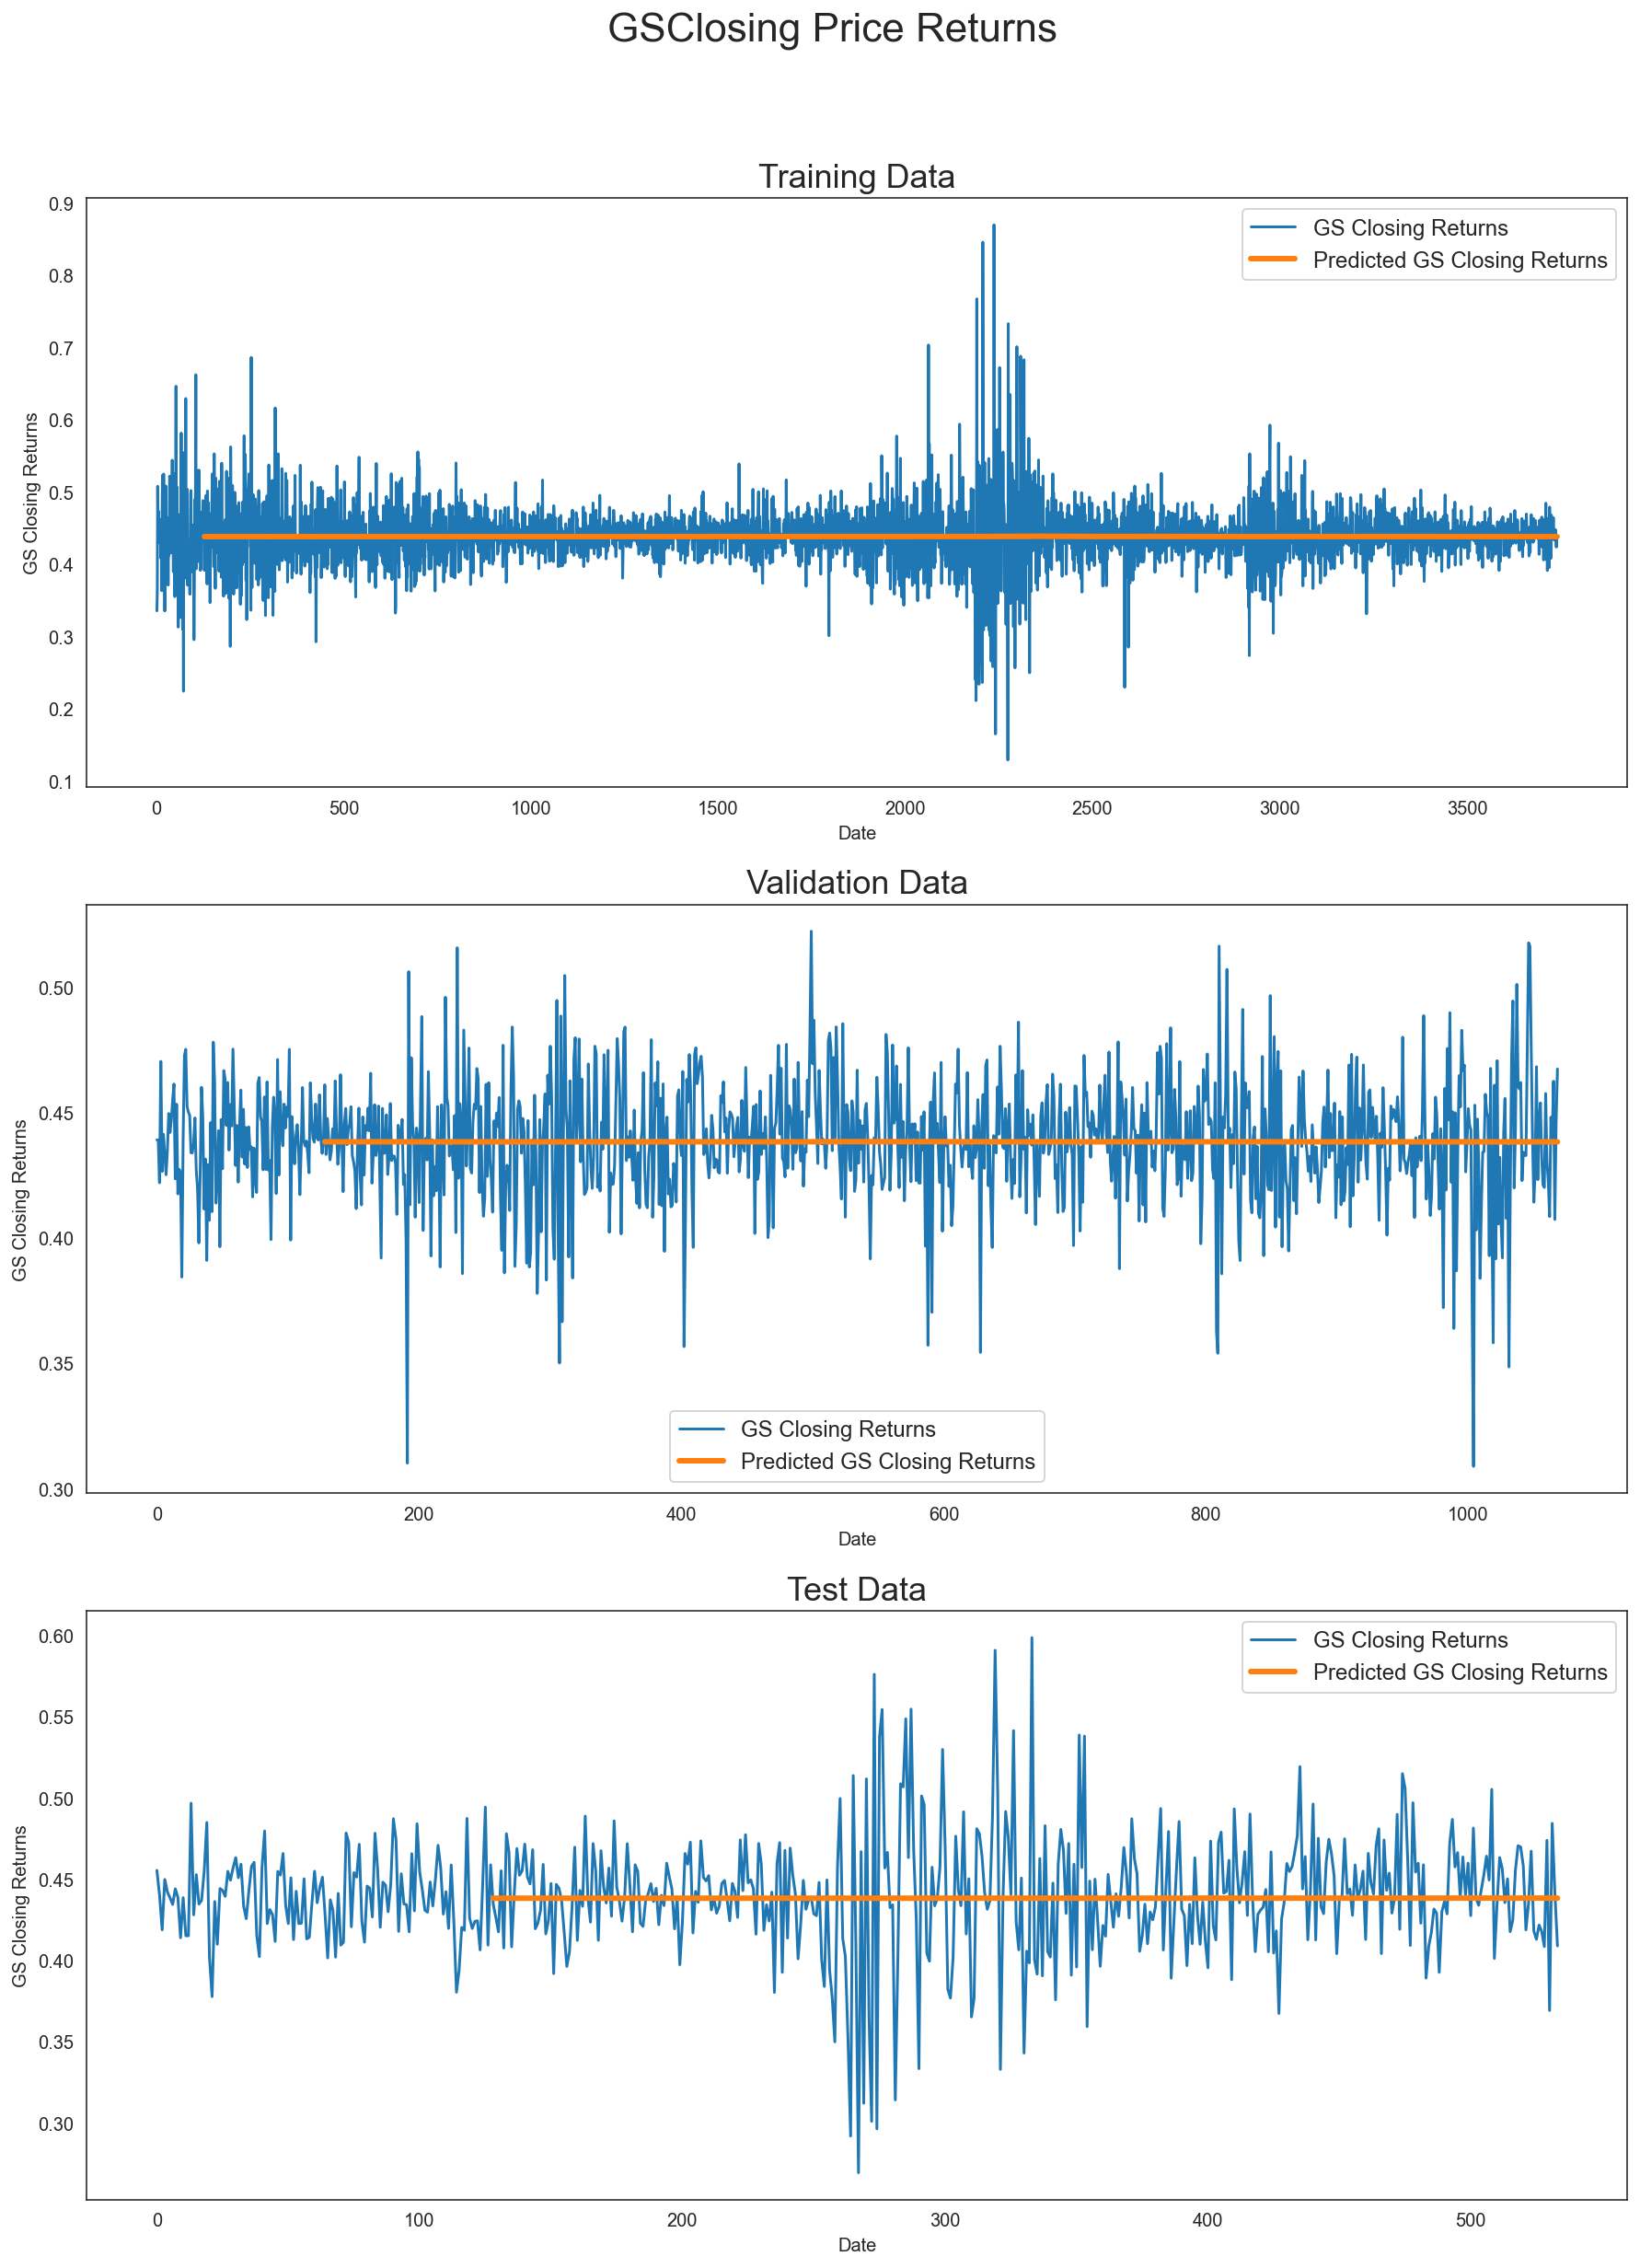

In [108]:
plot_prediction_result(pdic,[train_data,val_data.reset_index(),test_data.reset_index()],'Closing Price Returns')

### Plot Model Metrics

In [114]:
def plot_model_metrics(history, title):
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle(ticker + title, fontsize=22)
    st.set_y(0.92)

    #Plot MSE
    ax1 = fig.add_subplot(311)
    ax1.plot(history.history['loss'], label='Training loss (MSE)')
    ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
    ax1.set_title(f'{title} - Mean Square Error (MSE)', fontsize=15)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc='best', fontsize=15)

    #Plot MAE
    ax2 = fig.add_subplot(312)
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title(f'{title} - Mean Average Error (MAE)', fontsize=15)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Average Error (MAE)')
    ax2.legend(loc='best', fontsize=15)

    #Plot MAPE
    ax3 = fig.add_subplot(313)
    ax3.plot(history.history['mape'], label='Training MAPE')
    ax3.plot(history.history['val_mape'], label='Validation MAPE')
    ax3.set_title(f'{title} - Mean Average Percentage Error (MAPE)', fontsize=15)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Mean Average Percentage Error (MAPE)')
    ax3.legend(loc='best', fontsize=15)

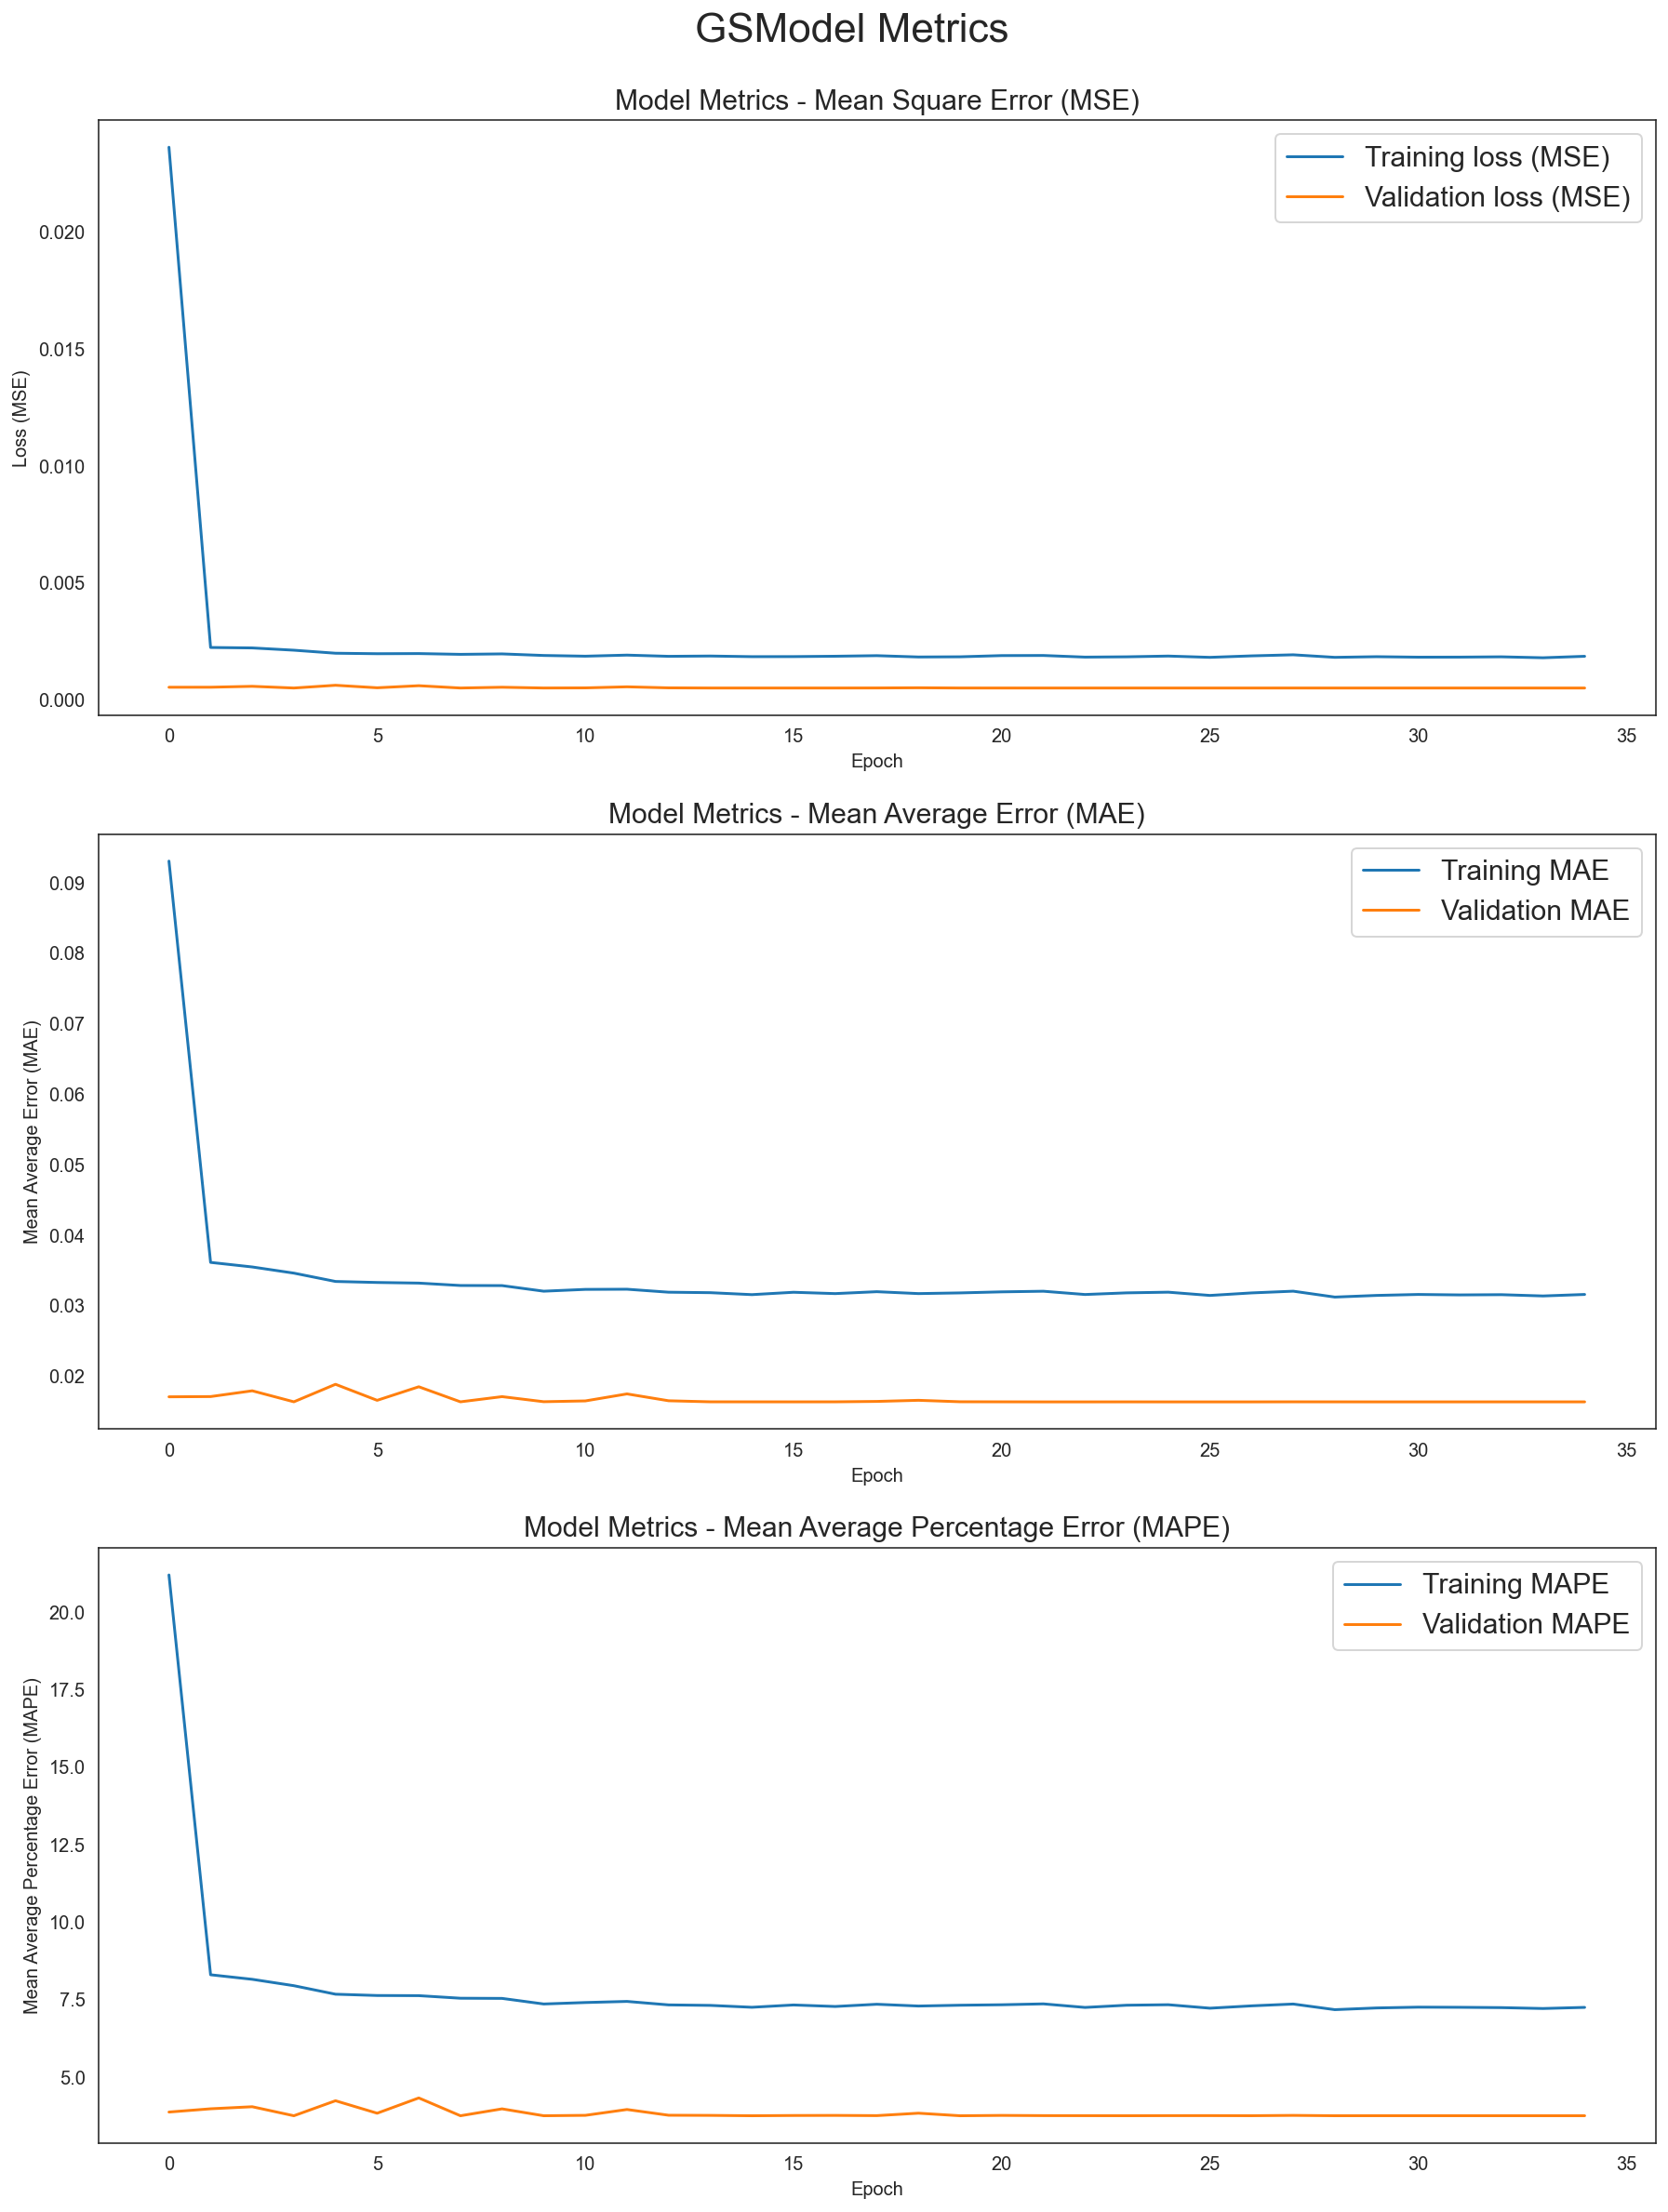

In [115]:
plot_model_metrics(history,'Model Metrics')

### Model Architecture Overview¶

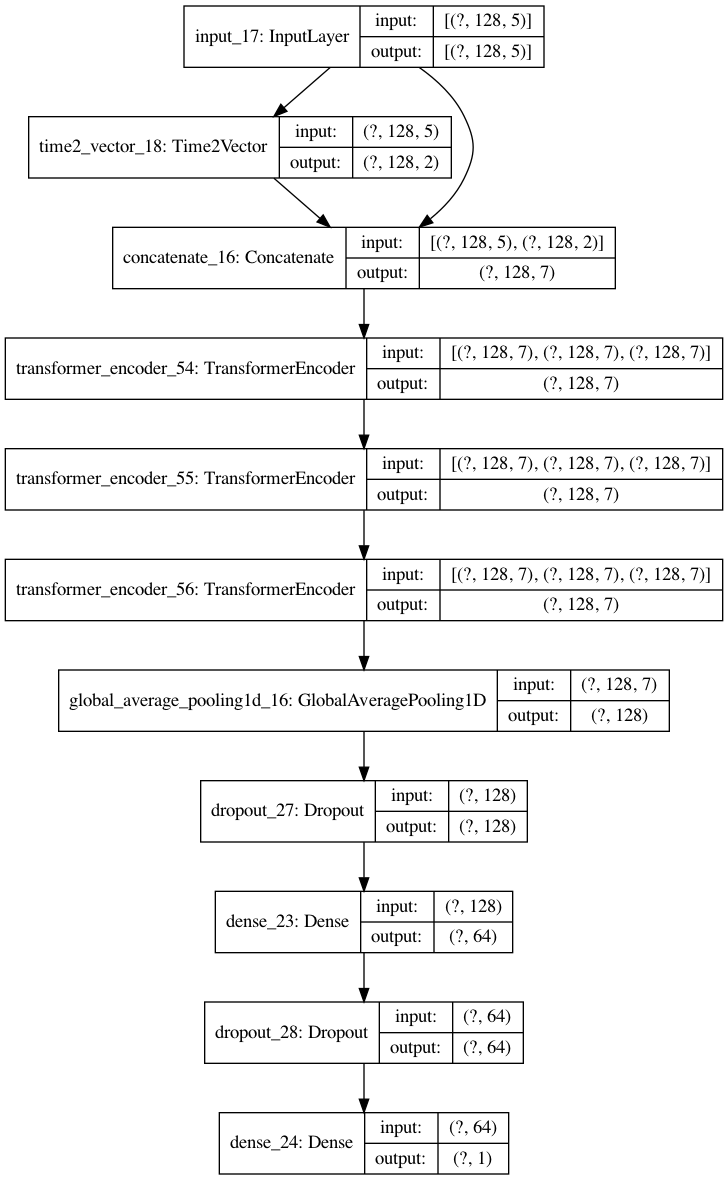

In [116]:
tf.keras.utils.plot_model(model,show_shapes=True,
                          show_layer_names=True,
                          expand_nested=True,
                          dpi=96)

## Smoothing the Data with SMA

- As shown above, even the transformer model architecture is not able to extract non-linear stock predictions from historical stock prices and volumes. 

- However, when applying a SMA smoothing effect on the data (ex: window size=10), the model is able to provide significantly better predictions
- Instead of predicting the linear trend, the model is able to predict the up and downs, too. 
- However, when observing carefully you can still see that the model has a large prediction delta on days with extreme daily change rate, hence we can conclude that we still have issues with outliers.

In [216]:
#Restore the backup backup
data=df_bkp.copy()
#Apply moving average with a window of 10 days to all columns
data.iloc[:,1:] = data.iloc[:,1:].rolling(10).mean() 
#Drop all rows with NaN values
data.dropna(how='any', axis=0, inplace=True) 
data.reset_index(inplace=True)
data.drop('index',1,inplace=True)
data.head()

Date      High       Low      Open     Close     Volume
0 2000-01-14  86.06250  82.47500  84.52500  83.84375  1180520.0
1 2000-01-18  85.53750  82.17500  83.60625  83.70000  1107830.0
2 2000-01-19  85.72500  82.62500  83.59375  84.18125  1006750.0
3 2000-01-20  86.33125  83.27500  84.20625  84.88750   917270.0
4 2000-01-21  86.50000  83.86875  84.96250  85.23125   787010.0

### Moving Average - Plot daily GS closing prices and volume

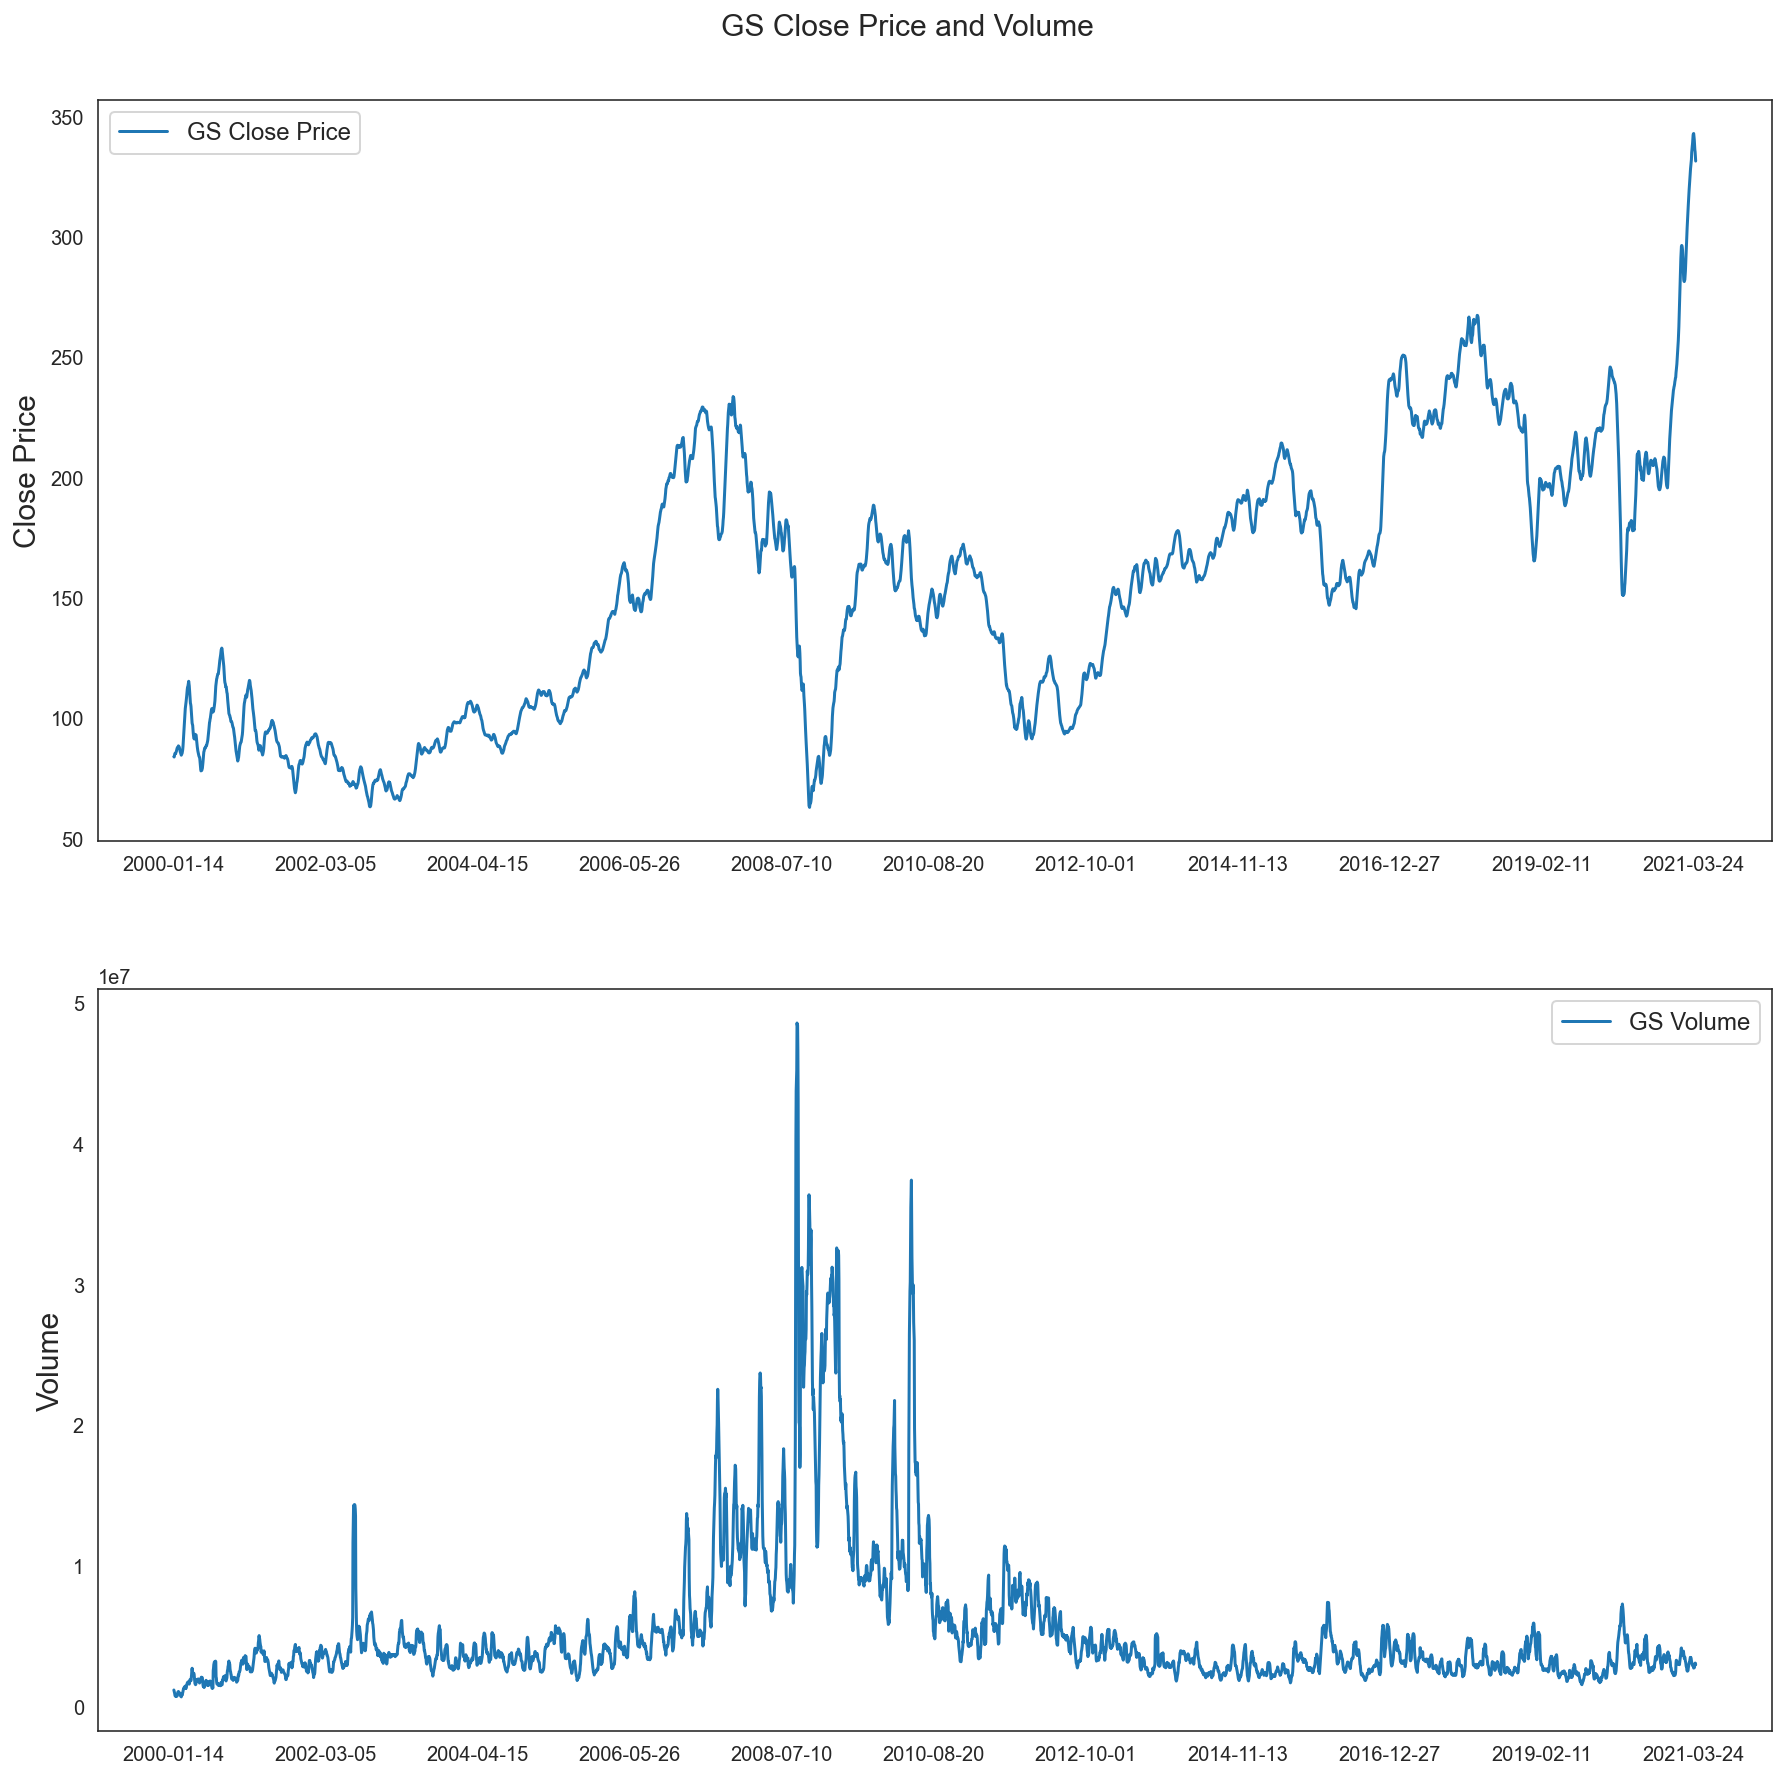

In [217]:
fig = plt.figure(figsize=(15,15))
st = fig.suptitle(f'{ticker} Close Price and Volume', fontsize=15)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(data.Close, label=f'{ticker} Close Price')
ax1.set_xticks(range(0, data.shape[0], int(len(data)/10)))
ax1.set_xticklabels(data['Date'].loc[::int(len(data)/10)].dt.date)
ax1.set_ylabel('Close Price', fontsize=15)
ax1.legend(loc='upper left', fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(data.Volume, label='GS Volume')
ax2.set_xticks(range(0, data.shape[0], int(len(data)/10)))
ax2.set_xticklabels(data['Date'].loc[::int(len(data)/10)].dt.date)
ax2.set_ylabel('Volume', fontsize=15)
ax2.legend(loc='best', fontsize=12);

### Normalization - After Smoothing the Data

In [218]:
#Normalize dataset -> 1st:Price features , 2nd: Other columns
data=norm_pct_minmax(data,1,5)
data.head()

Date      High       Low      Open     Close    Volume
1 2000-01-18  0.486213  0.512842  0.434643  0.533635  0.213554
2 2000-01-19  0.575876  0.611386  0.550557  0.614344  0.193599
3 2000-01-20  0.628643  0.637237  0.631401  0.642890  0.195187
4 2000-01-21  0.573309  0.629269  0.649283  0.595960  0.159450
5 2000-01-24  0.606082  0.573124  0.608648  0.541866  0.219546

### Split dataset into training, validation and testing

In [219]:
train_mdata,val_mdata,test_mdata=get_train_test_data(data,10,20)

Training Data shape: (4269, 5)
Validation Data shape: (534, 5)
Testing Data shape: (533, 5)


### Plots dataset after being splitted

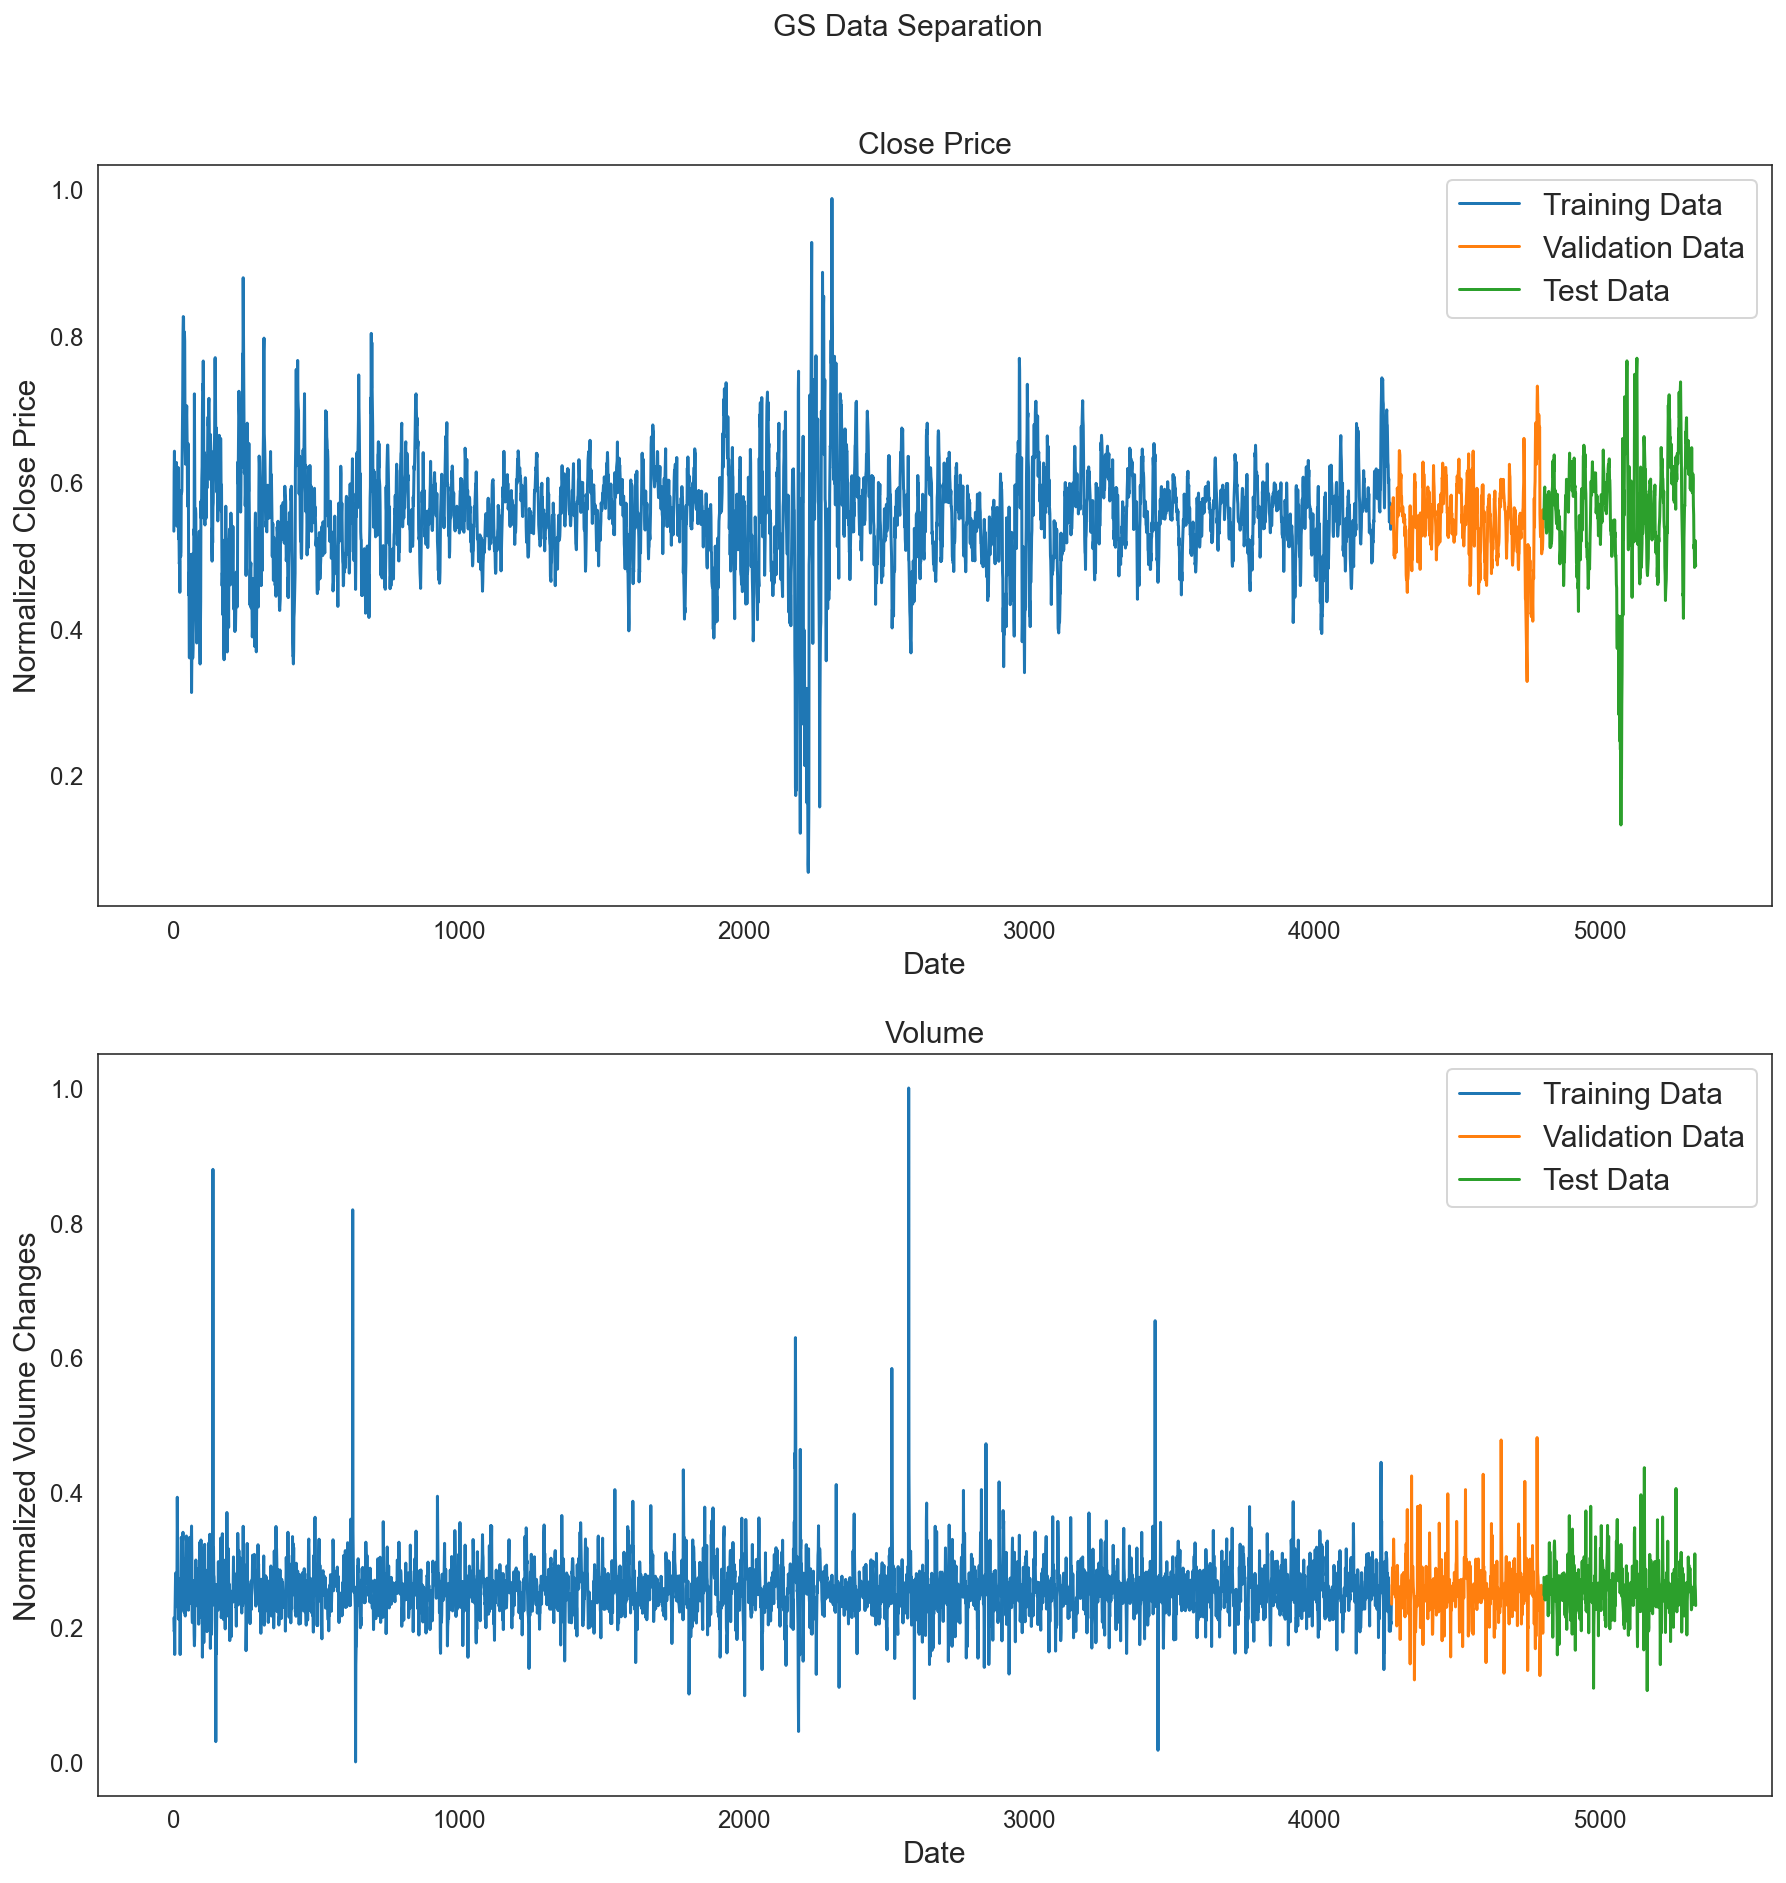

In [220]:
plot_data_separation(ticker, train_mdata, val_mdata, test_mdata, ['Close','Volume'])

### Create chunks of training, validation, and test data

In [221]:
X_mtrain, y_mtrain = split_dataset(train_mdata,seq_len,'Training Set Smoothed Data shape')
X_mval, y_mval = split_dataset(val_mdata,seq_len,'Validation Set Smoothed Data shape')
X_mtest, y_mtest = split_dataset(test_mdata,seq_len,'Testing Set Smoothed Data shape')

### Run Hyperparameters Search

- Performing search by using: 
    - KerasGridSearchCV
    - KerasRandomSearchCV

In [226]:
#Save the weighted updated model for further utilization in the next step
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint('model-smoothed.hdf5', monitor='val_loss', save_best_only=True, verbose=1)

In [227]:
param_grid_model={'d_k':d_k, 'd_v':d_v,'n_heads':n_heads, 
                  'ff_dim':ff_dim,'seq_len':seq_len,'act':'relu',
                  'dp':0.1,'optimizer':'adam'}

In [228]:
model_smoothed = create_model(param=param_grid_model,feat=len(train_mdata.columns))

In [229]:
history_smoothed = model_smoothed.fit(X_mtrain, y_mtrain, batch_size=batch_size, epochs=35, callbacks=[es,rlr,mcp], validation_data=(X_mval, y_mval))

Epoch 1/35
130/130 [==============================] - ETA: 0s - loss: 0.0314 - mae: 0.1111 - mape: 20.5148
Epoch 00001: val_loss improved from inf to 0.00280, saving model to model-smoothed.hdf5
130/130 [==============================] - 119s 917ms/step - loss: 0.0314 - mae: 0.1111 - mape: 20.5148 - val_loss: 0.0028 - val_mae: 0.0390 - val_mape: 7.4109
Epoch 2/35
130/130 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0604 - mape: 11.6142
Epoch 00002: val_loss did not improve from 0.00280
130/130 [==============================] - 124s 957ms/step - loss: 0.0063 - mae: 0.0604 - mape: 11.6142 - val_loss: 0.0028 - val_mae: 0.0400 - val_mape: 7.4341
Epoch 3/35
130/130 [==============================] - ETA: 0s - loss: 0.0060 - mae: 0.0592 - mape: 11.3595
Epoch 00003: val_loss did not improve from 0.00280
130/130 [==============================] - 118s 910ms/step - loss: 0.0060 - mae: 0.0592 - mape: 11.3595 - val_loss: 0.0028 - val_mae: 0.0391 - val_mape: 7.4145
Epoch 4/3

Epoch 26/35
130/130 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0284 - mape: 5.2802
Epoch 00026: val_loss did not improve from 0.00039
130/130 [==============================] - 133s 1s/step - loss: 0.0014 - mae: 0.0284 - mape: 5.2802 - val_loss: 3.8900e-04 - val_mae: 0.0149 - val_mape: 2.7867
Epoch 27/35
130/130 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0281 - mape: 5.2361
Epoch 00027: val_loss did not improve from 0.00039
130/130 [==============================] - 134s 1s/step - loss: 0.0014 - mae: 0.0281 - mape: 5.2361 - val_loss: 5.3939e-04 - val_mae: 0.0179 - val_mape: 3.4402
Epoch 28/35
130/130 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0273 - mape: 5.0822
Epoch 00028: val_loss did not improve from 0.00039
130/130 [==============================] - 134s 1s/step - loss: 0.0013 - mae: 0.0273 - mape: 5.0822 - val_loss: 4.4736e-04 - val_mae: 0.0161 - val_mape: 2.9626
Epoch 29/35
130/130 [=========================

### Load Weighted Model

In [230]:
model_smoothed = tf.keras.models.load_model(os.path.join(os.getcwd(),'model-smoothed.hdf5'),
                                   custom_objects={'Time2Vector': Time2Vector,
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

### Calculate Predictions & Metrics

In [231]:
#Get Predictions
p_mdic=calc_predict(model_smoothed,[X_mtrain,X_mval,X_mtest])

In [232]:
#Get Evaluation Metrics
e_mdic=eval_metrics(model_smoothed,[[X_mtrain, y_mtrain],[X_mval, y_mval],[X_mtest,y_mtest]])

In [233]:
#Print Evaluation Metrics
model_metric_summary([e_mdic[0],e_mdic[1],e_mdic[2]])

Loss (MSE)        MAE     MAPE
Training    0.000557187  0.0167808  3.13034
Validation  0.000295256  0.0128612  2.38483
Testing     0.000989758  0.0232309  4.41111

### Plot Predictions & Metrics

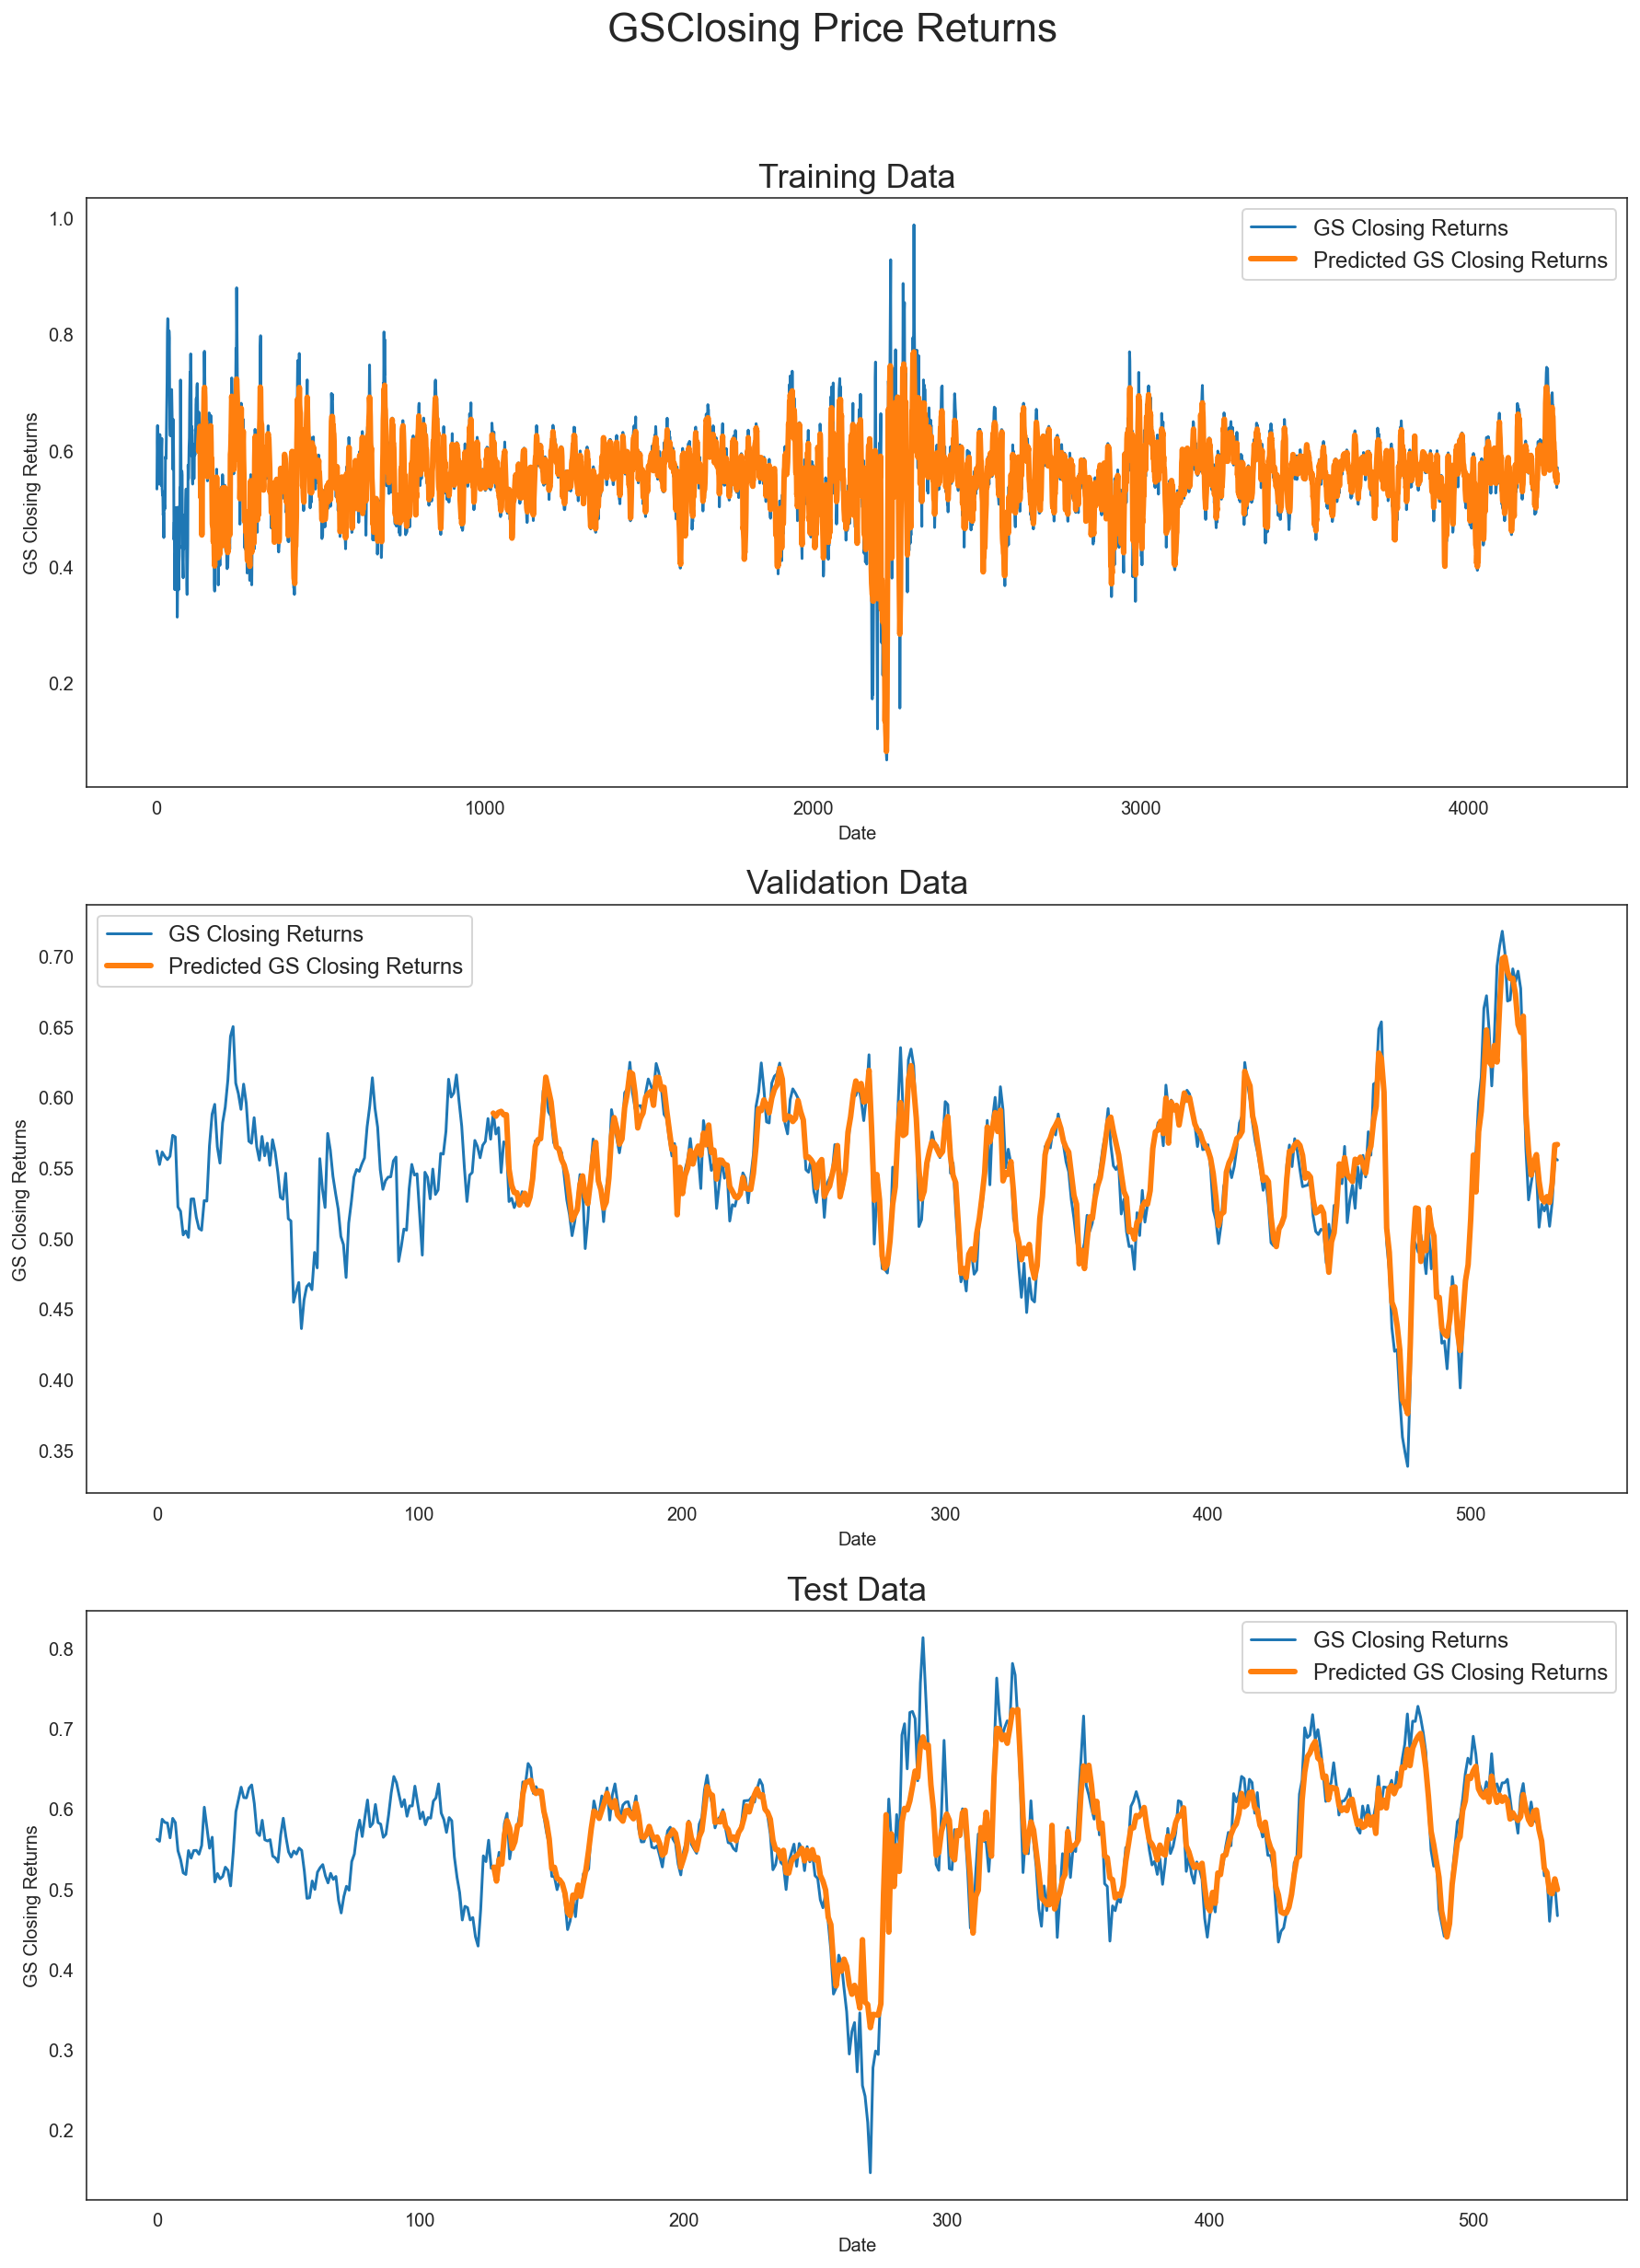

In [234]:
plot_prediction_result(p_mdic,[train_mdata,val_mdata.reset_index(),test_mdata.reset_index()],'Closing Price Returns')

### Plot Validation Loss & Accuracy Metrics

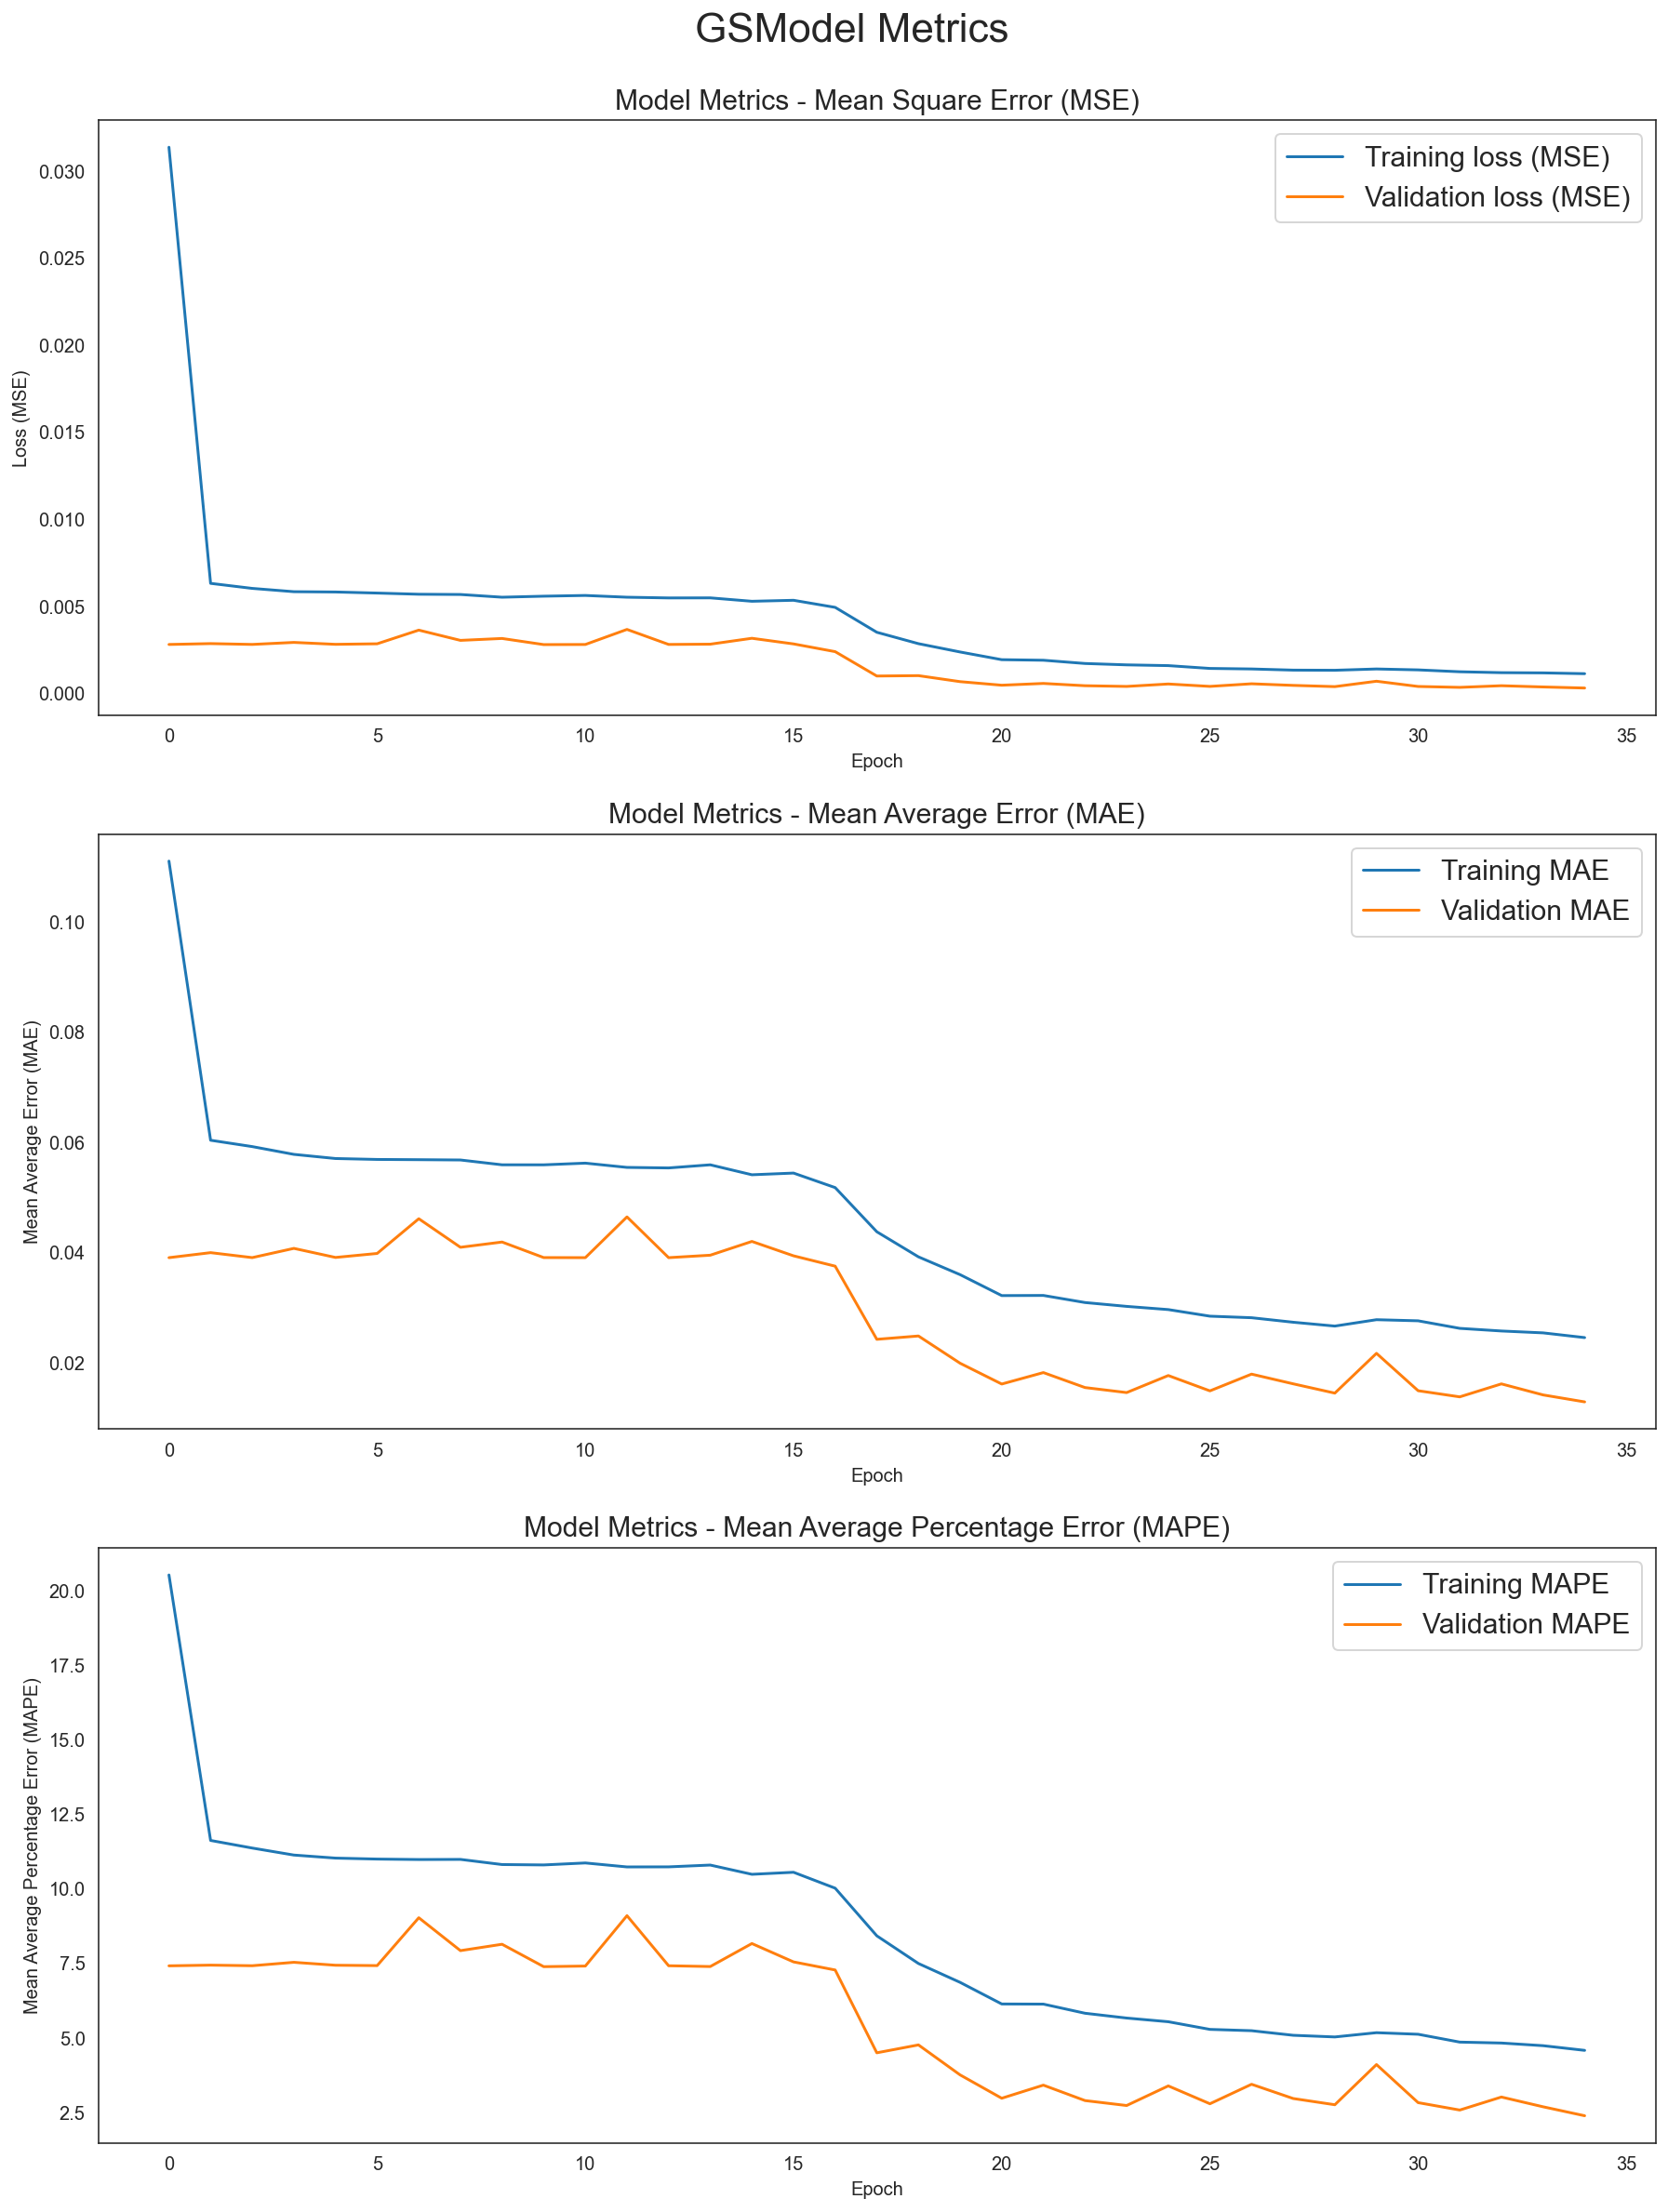

In [235]:
plot_model_metrics(history_smoothed,'Model Metrics')